<a href="https://colab.research.google.com/github/sabeesh90/Multimodal-Architectures-Deep_Learning/blob/main/Thesis_Sloan_Transfer_learning_advanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### <p style = "text-align:center"><font color  = 'blue'> Thesis Dissertation - Masters

#### Importing libraries

In [ ]:
from PIL import Image
import requests
from io import BytesIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import seaborn as sns
import warnings
import os
from skimage import io
import pathlib
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from tensorflow.keras.layers import *
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from sklearn.metrics import classification_report, confusion_matrix
!pip install -q -U keras-tuner
import kerastuner as kt
%load_ext tensorboard
warnings.filterwarnings("ignore")


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### <font color = "blue"> Custom Deep Learning model

#### **Tensorflow conventional loading dataset from directory**

In [ ]:
pip install Ipython

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/Colab Notebooks

[Errno 2] No such file or directory: 'drive/MyDrive/Colab Notebooks'
/content/drive/MyDrive/Colab Notebooks


In [ ]:
classes = ['GALAXY', 'QSO', 'STAR']

#### **Image augmentation code and testing using conventional tensorflow libraries**


##### Non rigid transformation  - Image augmentation

In [ ]:
data_augmentation  = tf.keras.Sequential(
    [layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"), # these are rigid transformation techniques  - flipping, rotation 
     layers.experimental.preprocessing.RandomRotation(0.2)])

data_cropping  = tf.keras.Sequential([layers.experimental.preprocessing.CenterCrop(1000,1000)])


In [ ]:
def generate_image(c = 0, n = 0, aug = False):
    dataset_path = 'Images'
    ast_class_path  = os.path.join(dataset_path, classes[c], '*')
    print(ast_class_path)
    # n = np.random.randint(0, len(ast_class_path))
    ast_image_path = glob.glob(ast_class_path)
    # print(ast_image_path[n])
    image = io.imread(ast_image_path[n])
        
    if aug == False:
        print(image.shape)
        plt.imshow(image)
        plt.show()
    else:
        plt.figure(figsize = (15,5))  
        print(image.shape)    
        image_expanded = tf.expand_dims(image,0)
        print(image.shape)  
        augmented_image = data_augmentation(image_expanded)
        cropped_image = data_cropping(image_expanded)
        plt.figure(figsize = (15,5))
        plt.subplot(1,3,1)
        plt.title('original_image')
        plt.imshow(image)
        plt.subplot(1,3,2)
        plt.title('augmented_image')
        plt.imshow(augmented_image[0])

        plt.subplot(1,3,3)
        plt.title('cropped_image')
        plt.imshow(cropped_image[0])

Images/GALAXY/*
(2048, 2048, 3)
(2048, 2048, 3)


<Figure size 1080x360 with 0 Axes>

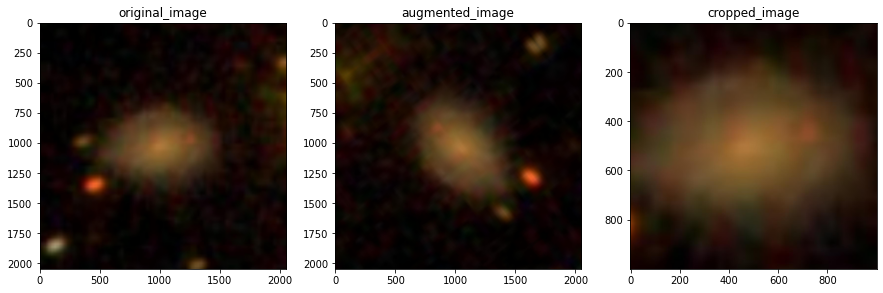

In [ ]:
generate_image(0,4, aug = True)

#### **Defining functions for code shortening**

In [ ]:
def generate_graph(model_training):
    plt.figure(figsize= (15,5))
    plt.subplot(1,2,1)
    plt.plot(model_training.history.history['accuracy'])
    plt.plot(model_training.history.history['val_accuracy'])
    plt.title('Training vs TestAccuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(('Training', 'Validation'), loc = 'best')
    plt.subplot(1,2,2)
    plt.plot(model_training.history.history['loss'])
    plt.plot(model_training.history.history['val_loss'])
    plt.title('Training loss vs Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(('Training', 'Validation'), loc = 'best')
    plt.show()

class Metrics:
    # from sklearn
    def __init__(self, model, val_ds):
        self.val_ds = val_ds
        self.model = model
        self.prediction_classes = np.array([])
        self.true_classes = np.array([])
        
    def calculate_scores(self):     
        print('calculating score.....')   
        
        for x, y in self.val_ds:
            self.prediction_classes = np.concatenate([self.prediction_classes,np.argmax(self.model.predict(x), axis = -1)])
            self.true_classes = np.concatenate([self.true_classes, np.argmax(y.numpy(), axis=-1)])
        
        class_report = classification_report(self.true_classes, self.prediction_classes)
        conf_matrix = confusion_matrix(self.true_classes, self.prediction_classes)
        print(conf_matrix)
        print('------------------------------------')
        print(class_report)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)

model_name_resnet = 'sloan_resnet' +'/'    
if not os.path.exists(model_name_resnet):
    os.mkdir(model_name_resnet)        
filepath_resnet = model_name_resnet + 'model-{epoch:05d}-{loss:.5f}-{accuracy:.5f}-{val_loss:.5f}-{val_accuracy:.5f}.h5'
model_checkpoint_callback_resnet = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath_resnet,
    monitor='val_accuracy',
    mode='auto',
    save_best_only=False,
    verbose = 1
    )
# callbacks_resnet = []
callbacks_resnet = [reduce_lr,model_checkpoint_callback_resnet]

model_name_vgg = 'sloan_vgg' +'/'    
if not os.path.exists(model_name_vgg):
    os.mkdir(model_name_vgg)        
filepath_vgg = model_name_vgg + 'model-{epoch:05d}-{loss:.5f}-{accuracy:.5f}-{val_loss:.5f}-{val_accuracy:.5f}.h5'
model_checkpoint_callback_vgg = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath_vgg,
    monitor='val_accuracy',
    mode='auto',
    save_best_only=False,
    verbose = 1
    )
# callbacks_vgg = [model_checkpoint_callback_vgg]
callbacks_vgg = [reduce_lr, model_checkpoint_callback_vgg]
model_name_xception = 'sloan_xception' +'/'    
if not os.path.exists(model_name_xception):
    os.mkdir(model_name_xception)        
filepath_xception = model_name_xception + 'model-{epoch:05d}-{loss:.5f}-{accuracy:.5f}-{val_loss:.5f}-{val_accuracy:.5f}.h5'
model_checkpoint_callback_xception = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath_xception,
    monitor='val_accuracy',
    mode='auto',
    save_best_only=False,
    verbose = 1
    )
# callbacks_xception = [model_checkpoint_callback_xception]
callbacks_xception = [reduce_lr, model_checkpoint_callback_xception]

model_name_efficient = 'sloan_efficient' +'/'    
if not os.path.exists(model_name_efficient):
    os.mkdir(model_name_efficient)        
filepath_efficient = model_name_efficient + 'model-{epoch:05d}-{loss:.2f}-{accuracy:.4f}-{val_loss:.2f}-{val_accuracy:.4f}.h5'
model_checkpoint_callback_efficient = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath_efficient,
    monitor='val_accuracy',
    mode='auto',
    save_best_only=False,
    verbose = 1
    )
# callbacks_efficient = [model_checkpoint_callback_efficient]
callbacks_efficient = [reduce_lr,model_checkpoint_callback_efficient]
model_name_dense = 'sloan_dense' +'/'    
if not os.path.exists(model_name_dense):
    os.mkdir(model_name_dense)        
filepath_dense = model_name_dense + 'model-{epoch:05d}-{loss:.2f}-{accuracy:.4f}-{val_loss:.2f}-{val_accuracy:.4f}.h5'
model_checkpoint_callback_dense = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath_dense,
    monitor='val_accuracy',
    mode='auto',
    save_best_only=False,
    verbose = 1
    )
# callbacks_dense = [model_checkpoint_callback_dense]
callbacks_dense = [reduce_lr,model_checkpoint_callback_dense]

#### Resnet 50

##### Data preparation

In [ ]:
# Preprocessing the data
dataset_path = 'Images'
img_width = 512
img_height = 512
channels = 3
num_classes = 3
batch_size = 8


img_width_crop = 1024
img_height_crop = 1024

rescale = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255)])


# augmenting the data
# cropless flip and rotate

data_aug_flip = tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                # layers.experimental.preprocessing.RandomRotation(0.2)])
])

data_aug_flip_rotate = tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                layers.experimental.preprocessing.RandomRotation(0.2)])


# crop flip and rotate
data_aug_crop_flip_rotate = tf.keras.Sequential([layers.experimental.preprocessing.CenterCrop(512,512),
                                                 layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                                 layers.experimental.preprocessing.RandomRotation(0.2)])

data_aug_crop_flip = tf.keras.Sequential([layers.experimental.preprocessing.CenterCrop(512,512),
                                          layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")])

normal_crop = tf.keras.Sequential([layers.experimental.preprocessing.CenterCrop(512,512)],)
batch_size =32 
autotune = tf.data.AUTOTUNE

# Preparing the normal dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset_path, validation_split = 0.2,subset = 'training',seed = 123, image_size = (img_width, img_height), 
                                                                  batch_size = batch_size, label_mode = 'categorical',)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset_path, validation_split = 0.2,subset = 'validation',seed = 123, image_size = (img_width, img_height),
                                                                batch_size = batch_size, label_mode = 'categorical')

train_ds_cropped = tf.keras.preprocessing.image_dataset_from_directory(dataset_path, validation_split = 0.2,subset = 'training',seed = 123, image_size = (img_width_crop, img_height_crop), 
                                                                  batch_size = batch_size, label_mode = 'categorical',)
val_ds_cropped = tf.keras.preprocessing.image_dataset_from_directory(dataset_path, validation_split = 0.2,subset = 'validation',seed = 123, image_size = (img_width_crop, img_height_crop),
                                                                batch_size = batch_size, label_mode = 'categorical')


# preparing the scalred dataset
train_ds_scaled = train_ds.map(lambda x,y: (rescale(x, training = True), y), num_parallel_calls=autotune)
val_ds_scaled = val_ds.map(lambda x,y: (rescale(x, training = False), y), num_parallel_calls=autotune)
train_ds.prefetch(buffer_size=autotune)
val_ds.prefetch(buffer_size=autotune)

train_ds_scaled_cropped = train_ds_scaled.map(lambda x,y: (rescale(x, training = True), y), num_parallel_calls=autotune)
val_ds_scaled_cropped = val_ds_scaled.map(lambda x,y: (rescale(x, training = False), y), num_parallel_calls=autotune)

# augment function 
def prepare_dataset(ds, flip = False, flip_rotate = False):
    if flip == True:
        ds = ds.map(lambda x, y : (data_aug_flip(x, training = True), y), num_parallel_calls = autotune)
    elif flip_rotate == True:
        ds = ds.map(lambda x, y : (data_aug_flip_rotate(x, training = True), y), num_parallel_calls = autotune)
    
    return ds.prefetch(buffer_size =autotune)

def prepare_dataset_crop(ds, crop_flip = False, crop_flip_rotate = False):
    if crop_flip_rotate == True:
        ds = ds.map(lambda x, y : (data_aug_crop_flip_rotate(x, training = True), y), num_parallel_calls = autotune)
    elif crop_flip == True:
        ds = ds.map(lambda x, y : (data_aug_crop_flip(x, training = True), y), num_parallel_calls = autotune)
    
    return ds.prefetch(buffer_size =autotune)
    
def prepare_dataset_normal_crop(ds, training = True):
    ds = ds.map(lambda x, y : (normal_crop(x, training = training), y), num_parallel_calls = autotune)
    return ds.prefetch(buffer_size =autotune)
# 25 batches of 32 each and 7 batches of 32 each



Found 1000 files belonging to 3 classes.
Using 800 files for training.
Found 1000 files belonging to 3 classes.
Using 200 files for validation.
Found 1000 files belonging to 3 classes.
Using 800 files for training.
Found 1000 files belonging to 3 classes.
Using 200 files for validation.


##### Data Analysis

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)
[[[ 2.  0.  1.]
  [ 2.  0.  1.]
  [ 2.  0.  1.]
  ...
  [11.  6.  0.]
  [12.  7.  1.]
  [12.  7.  1.]]

 [[ 2.  0.  1.]
  [ 2.  0.  1.]
  [ 2.  0.  1.]
  ...
  [10.  5.  0.]
  [12.  7.  1.]
  [12.  7.  1.]]

 [[ 2.  0.  1.]
  [ 2.  0.  1.]
  [ 2.  0.  1.]
  ...
  [ 9.  4.  0.]
  [10.  5.  0.]
  [10.  5.  0.]]

 ...

 [[ 7.  3.  4.]
  [ 6.  2.  3.]
  [ 7.  3.  4.]
  ...
  [ 3.  3.  3.]
  [ 2.  2.  2.]
  [ 2.  2.  2.]]

 [[ 7.  3.  4.]
  [ 7.  3.  4.]
  [ 6.  2.  3.]
  ...
  [ 3.  3.  3.]
  [ 2.  2.  2.]
  [ 2.  2.  2.]]

 [[ 7.  3.  4.]
  [ 7.  3.  4.]
  [ 6.  2.  3.]
  ...
  [ 3.  3.  3.]
  [ 2.  2.  2.]
  [ 2.  2.  2.]]]


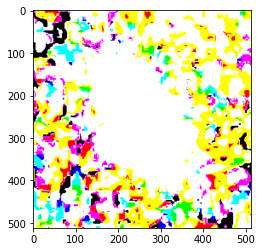

In [ ]:
# analysing the tensor
image = next(iter(train_ds))

# checking the shape of the tensor
print(image[0][0].numpy().shape)

# Taking the 5th image  from the batch
print(image[0][5].numpy())

# outputting the image from the batch
plt.imshow(image[0][5].numpy())



##### Resnet model building

In [ ]:
from tensorflow.keras.applications import  ResNet50
# loading the model
base_model = ResNet50(include_top=False, weights='imagenet', input_shape = (img_height, img_width, 3),classes = num_classes, pooling = 'avg',)
# base_model = ResNet50(include_top=False, weights='imagenet', input_shape = (img_height_crop, img_width_crop, 3),classes = num_classes, pooling = 'avg',)


In [ ]:
layer_count  = len(base_model.layers)
print(f'There are a total of {layer_count} in the resnet layer')
# making the base layers non trainable or freezing
break_point  = 150
for layer in base_model.layers[0:break_point]:
    layer.trainable = False
for layer in base_model.layers[break_point:]:
    layer.trainable = True

# please note higher the break point ; lesser the trainable layers lesser is the over fitting -> high breakpoint -> less over fitting 

There are a total of 176 in the resnet layer


In [ ]:
print(base_model.inputs)
input_layer = base_model.inputs

# Building a functional model
output = base_model.output
x = Dense(512, activation  = 'relu')(output)
x = Dense(num_classes, activation  = 'softmax')(x)
resnet_model = Model(inputs = input_layer, outputs = x)

[<KerasTensor: shape=(None, 512, 512, 3) dtype=float32 (created by layer 'input_3')>]


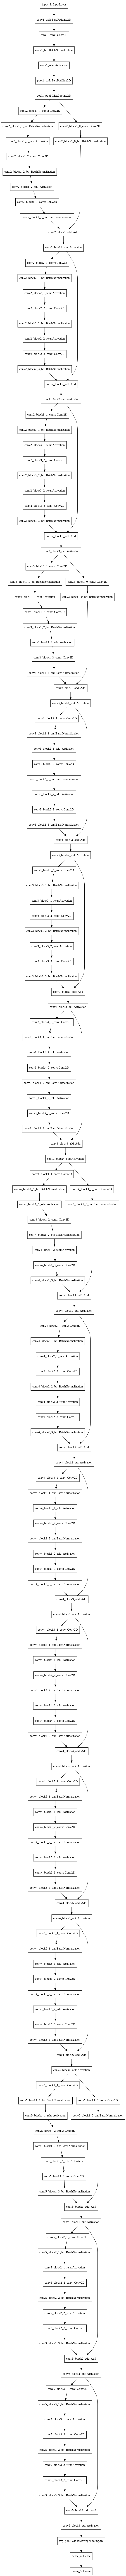

In [ ]:

keras.utils.plot_model(resnet_model)

In [ ]:
resnet_model.summary()
resnet_model.compile(optimizer = optimizers.Adam(lr=1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

##### Resnet model with normalization of  image pixels

In [ ]:
resnet_model.fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 60, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = callbacks_resnet)

Epoch 1/60
25/25 [==============================] - 15s 429ms/step - loss: 1.8013 - accuracy: 0.3338 - val_loss: 1.4713 - val_accuracy: 0.0850

Epoch 00001: saving model to sloan_resnet/model-00001-1.80129-0.33375-1.47130-0.08500.h5
Epoch 2/60
25/25 [==============================] - 11s 402ms/step - loss: 1.6323 - accuracy: 0.3725 - val_loss: 1.3293 - val_accuracy: 0.0850

Epoch 00002: saving model to sloan_resnet/model-00002-1.63225-0.37250-1.32931-0.08500.h5
Epoch 3/60
25/25 [==============================] - 11s 398ms/step - loss: 1.3644 - accuracy: 0.6350 - val_loss: 1.2081 - val_accuracy: 0.4800

Epoch 00003: saving model to sloan_resnet/model-00003-1.36443-0.63500-1.20806-0.48000.h5
Epoch 4/60
25/25 [==============================] - 11s 399ms/step - loss: 1.0192 - accuracy: 0.6787 - val_loss: 1.5411 - val_accuracy: 0.0850

Epoch 00004: saving model to sloan_resnet/model-00004-1.01923-0.67875-1.54108-0.08500.h5
Epoch 5/60
25/25 [==============================] - 11s 401ms/step -

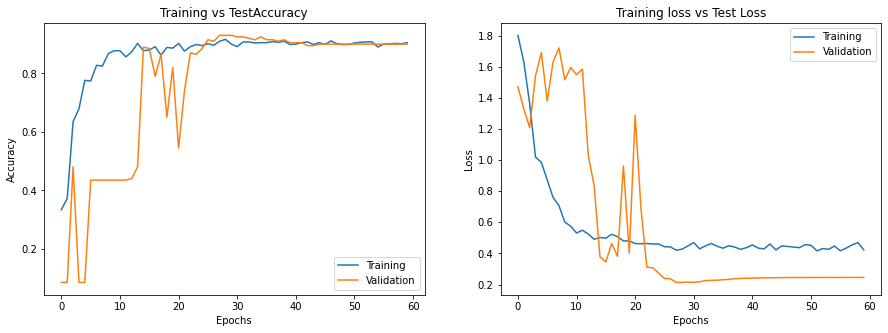

In [ ]:
generate_graph(resnet_model)

In [ ]:
r1 = load_model('./sloan_resnet/model-00029-0.42730-0.91625-0.21394-0.93000.h5')

In [ ]:

metrics = Metrics(r1,val_ds_scaled)
print(metrics.calculate_scores())

calculating score.....
[[93  0  3]
 [ 0 10  7]
 [ 1  3 83]]
------------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98        96
         1.0       0.77      0.59      0.67        17
         2.0       0.89      0.95      0.92        87

    accuracy                           0.93       200
   macro avg       0.88      0.84      0.86       200
weighted avg       0.93      0.93      0.93       200

None


##### Resnet model without scaling of images

In [ ]:
resnet_model.fit(train_ds,validation_data=val_ds, epochs = 10, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = callbacks_resnet)

Epoch 1/10
25/25 [==============================] - 13s 460ms/step - loss: 0.6505 - accuracy: 0.8737 - val_loss: 0.3098 - val_accuracy: 0.8650

Epoch 00001: val_accuracy improved from 0.81000 to 0.86500, saving model to sloan_resnet/model-00001-0.65051-0.87375-0.30978-0.86500.h5
Epoch 2/10
25/25 [==============================] - 12s 417ms/step - loss: 0.2463 - accuracy: 0.9388 - val_loss: 0.3468 - val_accuracy: 0.9000

Epoch 00002: val_accuracy improved from 0.86500 to 0.90000, saving model to sloan_resnet/model-00002-0.24633-0.93875-0.34678-0.90000.h5
Epoch 3/10
25/25 [==============================] - 12s 418ms/step - loss: 0.0992 - accuracy: 0.9775 - val_loss: 0.4575 - val_accuracy: 0.8950

Epoch 00003: val_accuracy did not improve from 0.90000
Epoch 4/10
25/25 [==============================] - 12s 413ms/step - loss: 0.0299 - accuracy: 0.9950 - val_loss: 0.2832 - val_accuracy: 0.9100

Epoch 00004: val_accuracy improved from 0.90000 to 0.91000, saving model to sloan_resnet/model-00

##### Augmentation Experiments

In [ ]:
train_ds_flip = prepare_dataset(train_ds_scaled, flip= True)
train_ds_flip_rotate = prepare_dataset(train_ds_scaled, flip_rotate = True)
train_ds_crop_flip = prepare_dataset_crop(train_ds_scaled_cropped, crop_flip = True)
train_ds_crop_flip_rotate = prepare_dataset_crop(train_ds_scaled_cropped, crop_flip_rotate = True)


##### resnet_scaled_flip_model

In [ ]:
r1.fit(train_ds_flip,validation_data=val_ds_scaled, epochs = 10, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = callbacks_resnet)

Epoch 1/10
25/25 [==============================] - 14s 442ms/step - loss: 0.4945 - accuracy: 0.9025 - val_loss: 0.3166 - val_accuracy: 0.8650

Epoch 00001: saving model to sloan_resnet/model-00001-0.49449-0.90250-0.31663-0.86500.h5
Epoch 2/10
25/25 [==============================] - 12s 418ms/step - loss: 0.4600 - accuracy: 0.9062 - val_loss: 0.2947 - val_accuracy: 0.8650

Epoch 00002: saving model to sloan_resnet/model-00002-0.46004-0.90625-0.29469-0.86500.h5
Epoch 3/10
25/25 [==============================] - 12s 419ms/step - loss: 0.4762 - accuracy: 0.9050 - val_loss: 0.2628 - val_accuracy: 0.8900

Epoch 00003: saving model to sloan_resnet/model-00003-0.47618-0.90500-0.26285-0.89000.h5
Epoch 4/10
25/25 [==============================] - 12s 419ms/step - loss: 0.4454 - accuracy: 0.9062 - val_loss: 0.2783 - val_accuracy: 0.8800

Epoch 00004: saving model to sloan_resnet/model-00004-0.44540-0.90625-0.27826-0.88000.h5
Epoch 5/10
25/25 [==============================] - 12s 426ms/step -

In [ ]:
metrics = Metrics(r1,val_ds_scaled)
print(metrics.calculate_scores())

calculating score.....
[[93  0  3]
 [ 0 13  4]
 [ 1 16 70]]
------------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98        96
         1.0       0.45      0.76      0.57        17
         2.0       0.91      0.80      0.85        87

    accuracy                           0.88       200
   macro avg       0.78      0.85      0.80       200
weighted avg       0.91      0.88      0.89       200

None


##### resnet_scaled_flip_rotate_model

In [ ]:
r1.fit(train_ds_flip_rotate,validation_data=val_ds_scaled, epochs = 40, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = callbacks_resnet)

Epoch 1/40
25/25 [==============================] - 25s 915ms/step - loss: 0.4587 - accuracy: 0.9038 - val_loss: 0.2596 - val_accuracy: 0.8800

Epoch 00001: saving model to sloan_resnet/model-00001-0.45873-0.90375-0.25960-0.88000.h5
Epoch 2/40
25/25 [==============================] - 18s 601ms/step - loss: 0.4559 - accuracy: 0.8938 - val_loss: 0.2630 - val_accuracy: 0.8800

Epoch 00002: saving model to sloan_resnet/model-00002-0.45592-0.89375-0.26298-0.88000.h5
Epoch 3/40
25/25 [==============================] - 18s 632ms/step - loss: 0.5004 - accuracy: 0.9062 - val_loss: 0.2717 - val_accuracy: 0.8800

Epoch 00003: saving model to sloan_resnet/model-00003-0.50038-0.90625-0.27171-0.88000.h5
Epoch 4/40
25/25 [==============================] - 18s 611ms/step - loss: 0.4453 - accuracy: 0.9075 - val_loss: 0.2758 - val_accuracy: 0.8800

Epoch 00004: saving model to sloan_resnet/model-00004-0.44527-0.90750-0.27576-0.88000.h5
Epoch 5/40
25/25 [==============================] - 18s 609ms/step -

KeyboardInterrupt: ignored

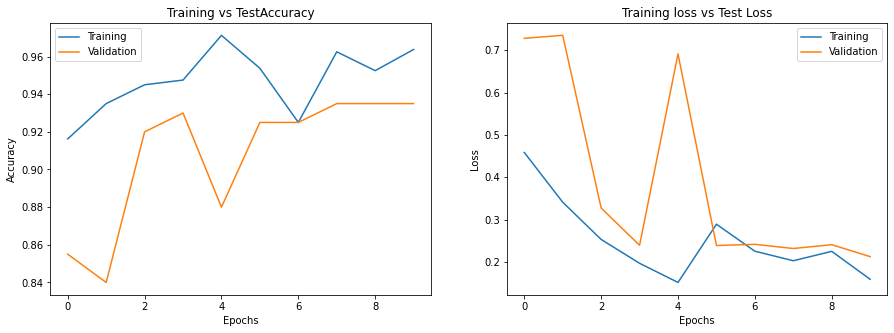

In [ ]:
generate_graph(resnet_non_scaled_flip_rotate)

In [ ]:
##### Resnet non scaled crop flip

##### Resnet scaled crop flip

In [ ]:
r1.fit(train_ds_crop_flip,validation_data=val_ds_scaled, epochs = 10, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = callbacks_resnet)

Epoch 1/10
25/25 [==============================] - 21s 633ms/step - loss: 0.6519 - accuracy: 0.8763 - val_loss: 2.0037 - val_accuracy: 0.5300

Epoch 00001: saving model to sloan_resnet/model-00001-0.65191-0.87625-2.00372-0.53000.h5
Epoch 2/10
25/25 [==============================] - 18s 594ms/step - loss: 0.3132 - accuracy: 0.9413 - val_loss: 1.8513 - val_accuracy: 0.6000

Epoch 00002: saving model to sloan_resnet/model-00002-0.31316-0.94125-1.85134-0.60000.h5
Epoch 3/10
25/25 [==============================] - 18s 594ms/step - loss: 0.1990 - accuracy: 0.9588 - val_loss: 2.7986 - val_accuracy: 0.4350

Epoch 00003: saving model to sloan_resnet/model-00003-0.19897-0.95875-2.79857-0.43500.h5
Epoch 4/10
25/25 [==============================] - 18s 595ms/step - loss: 0.1870 - accuracy: 0.9688 - val_loss: 2.1475 - val_accuracy: 0.4600

Epoch 00004: saving model to sloan_resnet/model-00004-0.18705-0.96875-2.14752-0.46000.h5
Epoch 5/10
25/25 [==============================] - 18s 578ms/step -

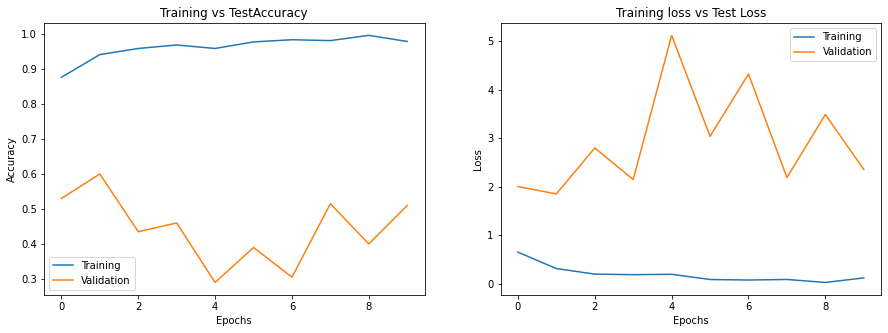

In [ ]:
generate_graph(resnet_non_scaled_crop_flip)

##### Resnet non normalized crop flip and rotate

In [ ]:
r1.fit(train_ds_crop_flip_rotate,validation_data=val_ds_scaled, epochs = 10, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = callbacks_resnet)

Epoch 1/10
25/25 [==============================] - 26s 809ms/step - loss: 0.6087 - accuracy: 0.8875 - val_loss: 2.2722 - val_accuracy: 0.4750

Epoch 00001: saving model to sloan_resnet/model-00001-0.60873-0.88750-2.27223-0.47500.h5
Epoch 2/10
25/25 [==============================] - 23s 773ms/step - loss: 0.4571 - accuracy: 0.8975 - val_loss: 2.7879 - val_accuracy: 0.4600

Epoch 00002: saving model to sloan_resnet/model-00002-0.45712-0.89750-2.78795-0.46000.h5
Epoch 3/10
25/25 [==============================] - 23s 742ms/step - loss: 0.3124 - accuracy: 0.9425 - val_loss: 2.9061 - val_accuracy: 0.4250

Epoch 00003: saving model to sloan_resnet/model-00003-0.31242-0.94250-2.90613-0.42500.h5
Epoch 4/10
25/25 [==============================] - 23s 762ms/step - loss: 0.2712 - accuracy: 0.9500 - val_loss: 3.4955 - val_accuracy: 0.4250

Epoch 00004: saving model to sloan_resnet/model-00004-0.27124-0.95000-3.49550-0.42500.h5
Epoch 5/10
25/25 [==============================] - 23s 770ms/step -

##### Resnet  - Preprocessing cropped as dataset not augmentation

In [ ]:
train_ds_normal_crop = prepare_dataset_normal_crop(train_ds_scaled_cropped) 
val_ds_normal_crop = prepare_dataset_normal_crop(val_ds_scaled_cropped, training = False)
resnet_model.fit(train_ds_normal_crop, validation_data = val_ds_normal_crop, epochs = 10, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = callbacks_resnet)


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/10
25/25 [==============================] - 116s 3s/step - loss: 0.8338 - accuracy: 0.8138 - val_loss: 0.3512 - val_accuracy: 0.8750

Epoch 00001: saving model to sloan_resnet/model-00001-0.83378-0.81375-0.35125-0.87500.h5
Epoch 2/10
25/25 [==============================] - 14s 453ms/step - loss: 0.1558 - accuracy: 0.9712 - val_loss: 0.3413 - val_accuracy: 0.8750

Epoch 00002: saving model to sloan_resnet/model-00002-0.15582-0.97125-0.34129-0.87500.h5
Epoch 3/10
25/25 [==============================] - 14s 454ms/step - loss: 0.1049 - accuracy: 0.9787 - val_loss: 0.5441 - val_accuracy: 0.7950

Epoch 00003: saving model to sloan_resnet/model-00003-0.10486-0.97875-0.54411-0.79500.h5
Epoch 4/10
25/25 [==============================] - 14s 455ms/step - loss: 0.0301 - accuracy: 0.9937 - val_loss: 0.3461 - val_accuracy: 0.9100

Epoch 00004: saving m

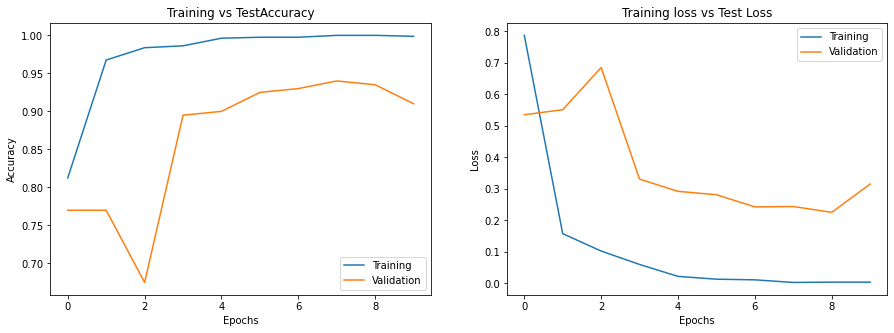

In [ ]:
generate_graph(resnet_model)

##### Model Evaluation

In [ ]:
resnet_normalized_43 = load_model('./sloan_resnet/resnet_normalized_43.h5')
resenet_non_normalized_93_90 = load_model('./sloan_resnet/resenet_non_normalized_93_90.h5')
resnet_non_normalized_flip_957_94 = load_model('./sloan_resnet/resnet_non_normalized_flip_95.7_94.h5')
resnet_non_normalized_flip_rotate_9475_94 = load_model('./sloan_resnet/resnet_non_normalized_flip_rotate_94.75_94.h5')
resnet_non_normalized_crop_flip_94_60 = load_model('./sloan_resnet/resnet_non_normalized_crop_flip_94_60.h5')
resnet_non_normalized_flip_crop_rotate_88_47 = load_model('./sloan_resnet/resnet_non_normalized_flip_crop_rotate_88_47.h5')
resnet_preprocessing_crop = load_model('./sloan_resnet/Resnet_normal_crop_non_aug-0.011-0.9975-0.24-0.93.h5')


In [ ]:
metrics = Metrics(resnet_model,val_ds_scaled)
print(metrics.calculate_scores())
print('---------------------------------------------------------------------------------------------------------------------')

calculating score.....
[[96  0  0]
 [ 0 13  4]
 [ 2 13 72]]
------------------------------------
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        96
         1.0       0.50      0.76      0.60        17
         2.0       0.95      0.83      0.88        87

    accuracy                           0.91       200
   macro avg       0.81      0.86      0.83       200
weighted avg       0.92      0.91      0.91       200

None
---------------------------------------------------------------------------------------------------------------------


In [ ]:
metrics = Metrics(resnet_normalized_93_81,val_ds)
print(metrics.calculate_scores())
print('---------------------------------------------------------------------------------------------------------------------')
metrics = Metrics(resenet_non_normalized_93_90,val_ds)
print(metrics.calculate_scores())
print('---------------------------------------------------------------------------------------------------------------------')
metrics = Metrics(resnet_non_normalized_flip_957_94,val_ds)
print(metrics.calculate_scores())
print('---------------------------------------------------------------------------------------------------------------------')
metrics = Metrics(resnet_non_normalized_flip_rotate_9475_94,val_ds)
print(metrics.calculate_scores())
print('---------------------------------------------------------------------------------------------------------------------')
metrics = Metrics(resnet_non_normalized_crop_flip_94_60,val_ds)
print(metrics.calculate_scores())
print('---------------------------------------------------------------------------------------------------------------------')
metrics = Metrics(resnet_non_normalized_flip_crop_rotate_88_47,val_ds)
print(metrics.calculate_scores())
print('---------------------------------------------------------------------------------------------------------------------')

calculating score.....
[[ 0  0 96]
 [ 0  0 17]
 [ 0  0 87]]
------------------------------------
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        96
         1.0       0.00      0.00      0.00        17
         2.0       0.43      1.00      0.61        87

    accuracy                           0.43       200
   macro avg       0.14      0.33      0.20       200
weighted avg       0.19      0.43      0.26       200

None
---------------------------------------------------------------------------------------------------------------------
calculating score.....
[[93  0  3]
 [ 0  3 14]
 [ 1  2 84]]
------------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98        96
         1.0       0.60      0.18      0.27        17
         2.0       0.83      0.97      0.89        87

    accuracy                           0.90       200
   macro avg       0.81      0

In [ ]:
metrics = Metrics(resnet_preprocessing_crop,val_ds_normal_crop)
print(metrics.calculate_scores())
print('---------------------------------------------------------------------------------------------------------------------')

calculating score.....
[[96  0  0]
 [ 2  8  7]
 [ 2  3 82]]
------------------------------------
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98        96
         1.0       0.73      0.47      0.57        17
         2.0       0.92      0.94      0.93        87

    accuracy                           0.93       200
   macro avg       0.87      0.80      0.83       200
weighted avg       0.92      0.93      0.92       200

None
---------------------------------------------------------------------------------------------------------------------


#### VGG 16

##### VGG model building

In [ ]:
base_model_vgg = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",    
    input_shape=(img_height, img_width, channels),
    pooling='max',
    classes=3,
)
layer_count  = len(base_model_vgg.layers)
print(f'There are a total of {layer_count} layers in the VGG 16 network')
# making the base layers non trainable or freezing

58892288/58889256 [==============================] - 0s 0us/step
There are a total of 20 layers in the VGG 16 network


In [ ]:
break_point  = 16
for layer in base_model_vgg.layers[0:break_point]:
    layer.trainable = False
for layer in base_model_vgg.layers[break_point:]:
    layer.trainable = True

# please note higher the break point ; lesser the trainable layers lesser is the over fitting -> high breakpoint -> less over fitting 
base_model_vgg.inputs
input_layer = base_model_vgg.inputs
# Building a functional model

output = base_model_vgg.output
output

<KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'global_max_pooling2d')>

In [ ]:
# x = Dense(1024, activation  = 'relu')(output)
x = Dense(num_classes, activation  = 'softmax')(output)

vgg_model = Model(inputs = input_layer, outputs = x)
vgg_model.summary()
vgg_model.compile(optimizer = optimizers.Adam(lr=1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0     

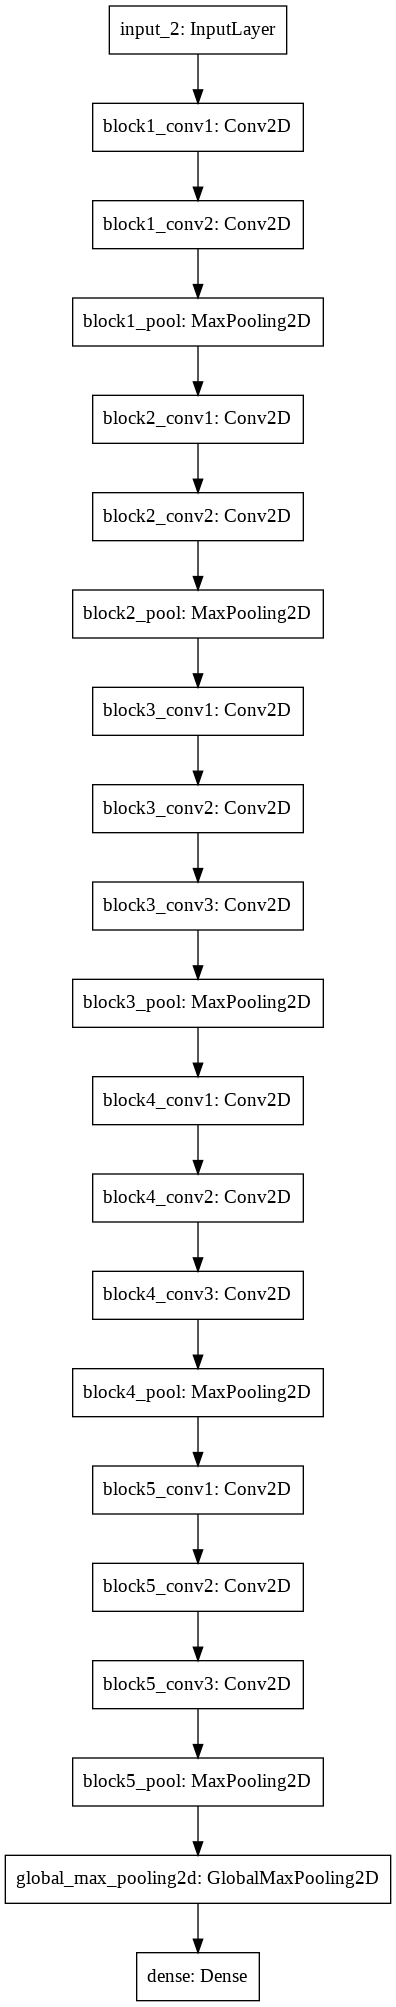

In [ ]:
keras.utils.plot_model(vgg_model)

##### VGG-16 scaled model

In [ ]:
vgg_model.fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 40, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = callbacks_vgg)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/40
25/25 [==============================] - 87s 2s/step - loss: 1.4359 - accuracy: 0.6388 - val_loss: 0.6811 - val_accuracy: 0.7850

Epoch 00001: saving model to sloan_resnet/model-00001-1.43590-0.63875-0.68114-0.78500.h5
Epoch 2/40
25/25 [==============================] - 12s 442ms/step - loss: 0.9198 - accuracy: 0.7713 - val_loss: 0.6016 - val_accuracy: 0.8100

Epoch 00002: saving model to sloan_resnet/model-00002-0.91983-0.77125-0.60156-0.81000.h5
Epoch 3/40
25/25 [==============================] - 12s 443ms/step - loss: 0.7846 - accuracy: 0.7925 - val_loss: 0.6329 - val_accuracy: 0.7200

Epoch 00003: saving model to sloan_resnet/model-00003-0.78463-0.79250-0.63287-0.72000.h5
Epoch 4/40
25/25 [==============================] - 12s 441ms/step - loss: 0.6860 - accuracy: 0.8275 - val_loss: 0.5185 - val_accuracy: 0.7950

Epoch 00004: saving mo

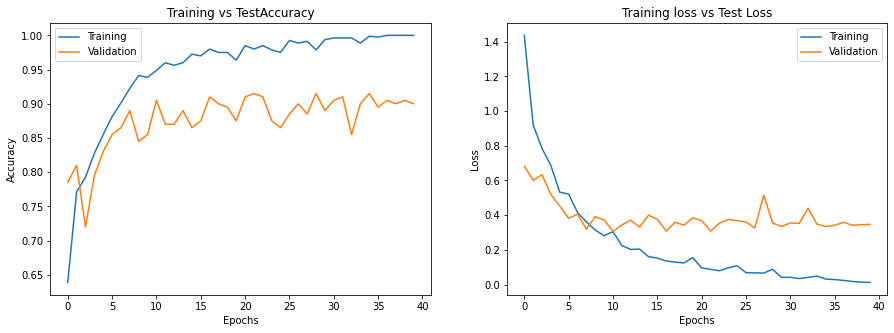

In [ ]:
generate_graph(vgg_model)

##### VGG 16 uscaled model

In [ ]:
vgg_model.fit(train_ds,validation_data=val_ds,epochs = 35, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = callbacks_vgg)

Epoch 1/35
25/25 [==============================] - 13s 449ms/step - loss: 1.2786 - accuracy: 0.8163 - val_loss: 0.9811 - val_accuracy: 0.7600

Epoch 00001: saving model to sloan_vgg/model-00001-1.27861-0.81625-0.98112-0.76000.h5
Epoch 2/35
25/25 [==============================] - 12s 444ms/step - loss: 0.2587 - accuracy: 0.9413 - val_loss: 0.7749 - val_accuracy: 0.8400

Epoch 00002: saving model to sloan_vgg/model-00002-0.25872-0.94125-0.77488-0.84000.h5
Epoch 3/35
25/25 [==============================] - 12s 445ms/step - loss: 0.0951 - accuracy: 0.9850 - val_loss: 0.8963 - val_accuracy: 0.8150

Epoch 00003: saving model to sloan_vgg/model-00003-0.09515-0.98500-0.89633-0.81500.h5
Epoch 4/35
25/25 [==============================] - 12s 446ms/step - loss: 0.0450 - accuracy: 0.9862 - val_loss: 0.7415 - val_accuracy: 0.8650

Epoch 00004: saving model to sloan_vgg/model-00004-0.04498-0.98625-0.74148-0.86500.h5
Epoch 5/35
25/25 [==============================] - 13s 448ms/step - loss: 0.015

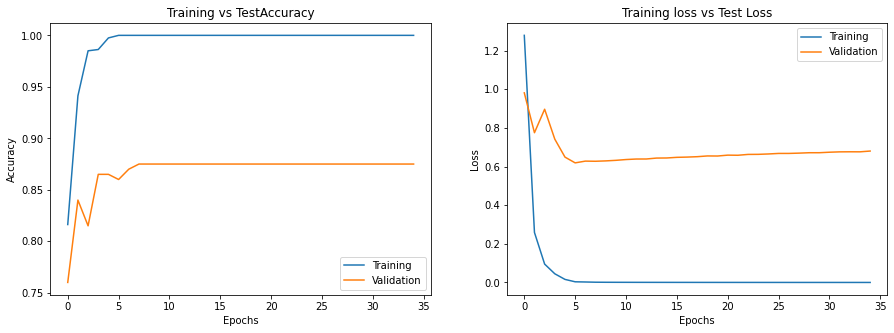

In [ ]:
generate_graph(vgg_model)

##### Augmentation experiments

In [ ]:
train_ds_flip = prepare_dataset(train_ds_scaled, flip= True)
train_ds_flip_rotate = prepare_dataset(train_ds_scaled, flip_rotate = True)
train_ds_crop_flip = prepare_dataset_crop(train_ds_scaled_cropped, crop_flip = True)
train_ds_crop_flip_rotate = prepare_dataset_crop(train_ds_scaled_cropped, crop_flip_rotate = True)

vgg_scaled_flip = load_model('./sloan_vgg/vgg16-scaled_0.36-92.25_0.32-089.h5')
vgg_scaled_flip_rotate = load_model('./sloan_vgg/vgg16-scaled_0.36-92.25_0.32-089.h5')
# this model is trained on the 
vgg_scaled_crop_flip = load_model('./sloan_vgg/vgg16-scaled_0.36-92.25_0.32-089.h5')
vgg_scaled_crop_flip_rotate = load_model('./sloan_vgg/vgg16-scaled_0.36-92.25_0.32-089.h5')

##### VGG scaled flip

In [ ]:
vgg_scaled_flip.fit(train_ds_flip,validation_data=val_ds_scaled,epochs = 40, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1},callbacks = callbacks_vgg)

Epoch 1/40
25/25 [==============================] - 13s 452ms/step - loss: 0.5809 - accuracy: 0.8763 - val_loss: 0.4137 - val_accuracy: 0.8600

Epoch 00001: saving model to sloan_vgg/model-00001-0.58092-0.87625-0.41365-0.86000.h5
Epoch 2/40
25/25 [==============================] - 13s 454ms/step - loss: 0.4376 - accuracy: 0.8913 - val_loss: 0.3183 - val_accuracy: 0.8800

Epoch 00002: saving model to sloan_vgg/model-00002-0.43763-0.89125-0.31833-0.88000.h5
Epoch 3/40
25/25 [==============================] - 13s 451ms/step - loss: 0.4332 - accuracy: 0.9137 - val_loss: 0.3345 - val_accuracy: 0.8600

Epoch 00003: saving model to sloan_vgg/model-00003-0.43316-0.91375-0.33454-0.86000.h5
Epoch 4/40
25/25 [==============================] - 13s 458ms/step - loss: 0.3711 - accuracy: 0.9200 - val_loss: 0.3278 - val_accuracy: 0.8850

Epoch 00004: saving model to sloan_vgg/model-00004-0.37113-0.92000-0.32777-0.88500.h5
Epoch 5/40
25/25 [==============================] - 13s 453ms/step - loss: 0.370

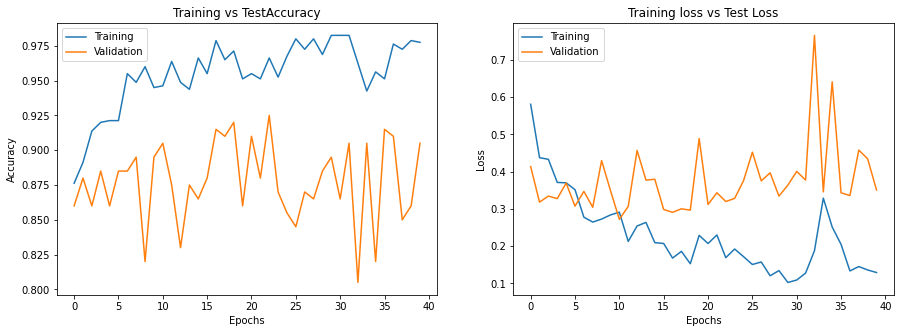

In [ ]:
generate_graph(vgg_scaled_flip)

##### VGG scaled flip rotate

In [ ]:
vgg_scaled_flip_rotate.fit(train_ds_flip_rotate,validation_data=val_ds_scaled,epochs = 40, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1},callbacks = callbacks_vgg)

Epoch 1/40
25/25 [==============================] - 19s 629ms/step - loss: 0.5575 - accuracy: 0.8675 - val_loss: 0.3667 - val_accuracy: 0.8600

Epoch 00001: saving model to sloan_vgg/model-00001-0.55748-0.86750-0.36666-0.86000.h5
Epoch 2/40
25/25 [==============================] - 19s 648ms/step - loss: 0.4819 - accuracy: 0.8838 - val_loss: 0.5301 - val_accuracy: 0.7950

Epoch 00002: saving model to sloan_vgg/model-00002-0.48191-0.88375-0.53011-0.79500.h5
Epoch 3/40
25/25 [==============================] - 18s 628ms/step - loss: 0.6089 - accuracy: 0.8500 - val_loss: 0.5684 - val_accuracy: 0.7850

Epoch 00003: saving model to sloan_vgg/model-00003-0.60889-0.85000-0.56844-0.78500.h5
Epoch 4/40
25/25 [==============================] - 18s 619ms/step - loss: 0.5080 - accuracy: 0.8813 - val_loss: 0.4461 - val_accuracy: 0.8200

Epoch 00004: saving model to sloan_vgg/model-00004-0.50805-0.88125-0.44609-0.82000.h5
Epoch 5/40
25/25 [==============================] - 18s 606ms/step - loss: 0.462

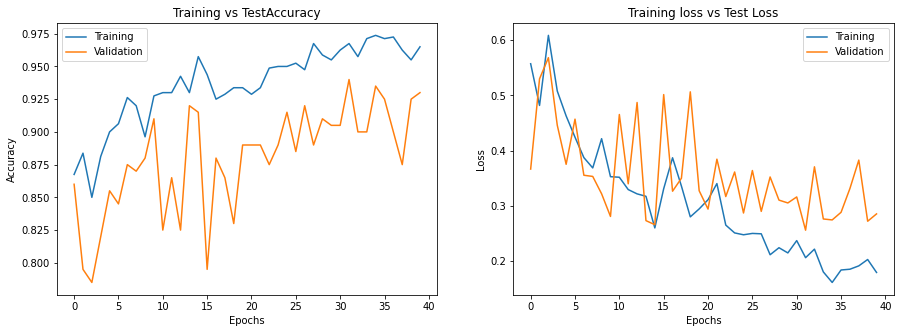

In [ ]:
generate_graph(vgg_scaled_flip_rotate)

##### VGG crop flip

In [ ]:
vgg_scaled_crop_flip.fit(train_ds_crop_flip,validation_data=val_ds_scaled_cropped,epochs = 40, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = callbacks_vgg)

Epoch 1/40
25/25 [==============================] - 13s 459ms/step - loss: 1.9000 - accuracy: 0.3713 - val_loss: 1.0387 - val_accuracy: 0.4800

Epoch 00001: saving model to sloan_vgg/model-00001-1.90001-0.37125-1.03868-0.48000.h5
Epoch 2/40
25/25 [==============================] - 13s 447ms/step - loss: 1.6070 - accuracy: 0.3388 - val_loss: 1.0856 - val_accuracy: 0.4350

Epoch 00002: saving model to sloan_vgg/model-00002-1.60702-0.33875-1.08561-0.43500.h5
Epoch 3/40
25/25 [==============================] - 13s 451ms/step - loss: 1.6047 - accuracy: 0.4588 - val_loss: 1.0837 - val_accuracy: 0.4350

Epoch 00003: saving model to sloan_vgg/model-00003-1.60470-0.45875-1.08370-0.43500.h5
Epoch 4/40
25/25 [==============================] - 13s 456ms/step - loss: 1.5988 - accuracy: 0.4525 - val_loss: 1.0798 - val_accuracy: 0.4350

Epoch 00004: saving model to sloan_vgg/model-00004-1.59878-0.45250-1.07979-0.43500.h5
Epoch 5/40
25/25 [==============================] - 13s 445ms/step - loss: 1.603

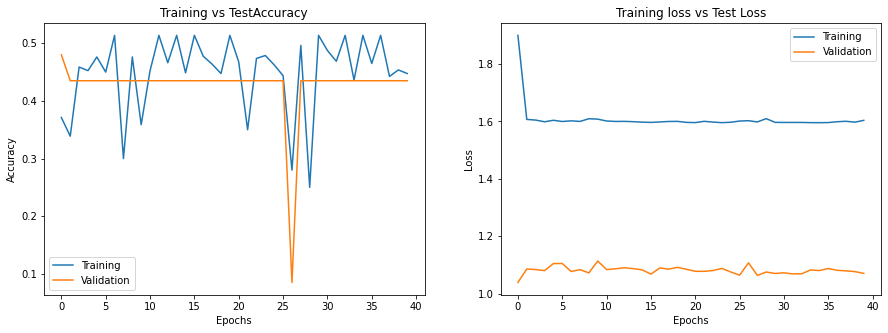

In [ ]:
generate_graph(vgg_scaled_crop_flip)

##### vgg crop flip rotate

In [ ]:
vgg_scaled_crop_flip_rotate.fit(train_ds_crop_flip_rotate,validation_data=val_ds_scaled_cropped,epochs = 40, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1},callbacks = callbacks_vgg)

Epoch 1/40
25/25 [==============================] - 27s 989ms/step - loss: 1.8818 - accuracy: 0.3487 - val_loss: 1.1389 - val_accuracy: 0.0850

Epoch 00001: saving model to sloan_vgg/model-00001-1.88177-0.34875-1.13890-0.08500.h5
Epoch 2/40
25/25 [==============================] - 27s 980ms/step - loss: 1.6099 - accuracy: 0.4363 - val_loss: 1.1225 - val_accuracy: 0.4350

Epoch 00002: saving model to sloan_vgg/model-00002-1.60987-0.43625-1.12248-0.43500.h5
Epoch 3/40
25/25 [==============================] - 27s 988ms/step - loss: 1.6055 - accuracy: 0.4125 - val_loss: 1.1103 - val_accuracy: 0.4350

Epoch 00003: saving model to sloan_vgg/model-00003-1.60545-0.41250-1.11033-0.43500.h5
Epoch 4/40
25/25 [==============================] - 27s 1s/step - loss: 1.6036 - accuracy: 0.3750 - val_loss: 1.0562 - val_accuracy: 0.4350

Epoch 00004: saving model to sloan_vgg/model-00004-1.60356-0.37500-1.05620-0.43500.h5
Epoch 5/40
25/25 [==============================] - 27s 976ms/step - loss: 1.5986 -

##### vgg scaled cropped - preprocessed

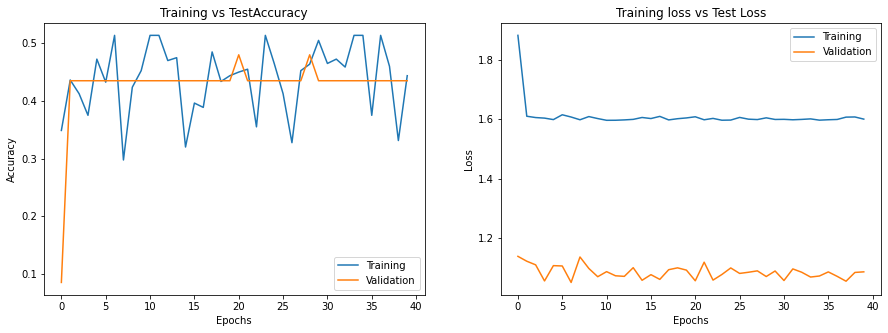

In [ ]:
generate_graph(vgg_scaled_crop_flip_rotate)

##### VGG 16 preprocess normal scaled crop 

In [ ]:
train_ds_normal_scaled_crop = prepare_dataset_normal_crop(train_ds_scaled_cropped) 
val_ds_normal_scaled_crop = prepare_dataset_normal_crop(val_ds_scaled_cropped, training = False)
vgg_model.fit(train_ds_normal_scaled_crop, validation_data = val_ds_normal_scaled_crop, epochs = 10, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = callbacks_vgg)


Epoch 1/10
25/25 [==============================] - 17s 407ms/step - loss: 1.7022 - accuracy: 0.3262 - val_loss: 1.0557 - val_accuracy: 0.4350

Epoch 00001: saving model to sloan_vgg/model-00001-1.70225-0.32625-1.05570-0.43500.h5
Epoch 2/10
25/25 [==============================] - 9s 320ms/step - loss: 1.6094 - accuracy: 0.3925 - val_loss: 1.0988 - val_accuracy: 0.4350

Epoch 00002: saving model to sloan_vgg/model-00002-1.60937-0.39250-1.09882-0.43500.h5
Epoch 3/10
25/25 [==============================] - 10s 322ms/step - loss: 1.6164 - accuracy: 0.4725 - val_loss: 1.0750 - val_accuracy: 0.4350

Epoch 00003: saving model to sloan_vgg/model-00003-1.61645-0.47250-1.07504-0.43500.h5
Epoch 4/10
25/25 [==============================] - 10s 327ms/step - loss: 1.6046 - accuracy: 0.3512 - val_loss: 1.0450 - val_accuracy: 0.4350

Epoch 00004: saving model to sloan_vgg/model-00004-1.60457-0.35125-1.04501-0.43500.h5
Epoch 5/10
25/25 [==============================] - 10s 325ms/step - loss: 1.6050

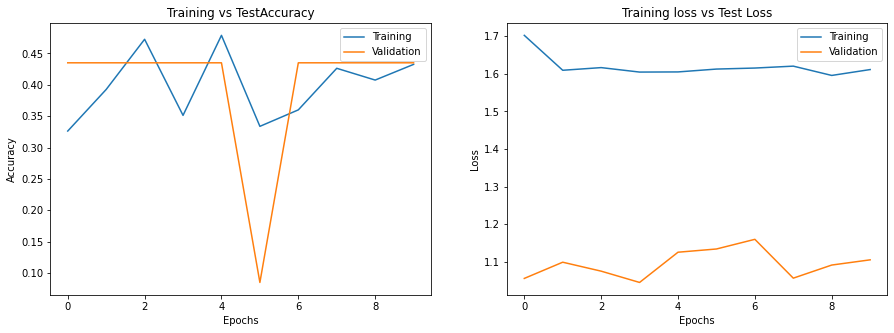

In [ ]:
generate_graph(vgg_model)

##### Model evaluation

In [ ]:
vgg_scaled = load_model('./sloan_vgg/vgg16-scaled_0.36-92.25_0.32-089.h5')
vgg_unscaled = load_model('./sloan_vgg/vgg16-unscaled-0.04_098.62-0.74_086.5.h5') 
vgg_scaled_flip = load_model('./sloan_vgg/VGG_scaled_flip0.16_96.62-0.31_92.50.h5')
vgg_scaled_flip_rotate = load_model('./sloan_vgg/vgg_16_sclaled_flip_rotate_0.20-0.9550_0.27-0.925.h5')
vgg_scaled_crop_flip = load_model('./sloan_vgg/vgg_scaled_crop_flip1.60-0.44_1.07-0.4350.h5')
vgg_scaled_crop_flip_rotate = load_model('./sloan_vgg/vgg16_scl_crop_flip_rotate1.6-0.43_1.12-0.43.h5')



metrics = Metrics(vgg_scaled,val_ds_scaled)
print(metrics.calculate_scores())
print('---------------------------------------------------------------------------------------------------------------------')
metrics = Metrics(vgg_unscaled,val_ds)
print(metrics.calculate_scores())
print('---------------------------------------------------------------------------------------------------------------------')
metrics = Metrics(vgg_scaled_flip,val_ds_scaled)
print(metrics.calculate_scores())
print('---------------------------------------------------------------------------------------------------------------------')
metrics = Metrics(vgg_scaled_flip_rotate,val_ds_scaled)
print(metrics.calculate_scores())
print('---------------------------------------------------------------------------------------------------------------------')
metrics = Metrics(vgg_scaled_crop_flip,val_ds_scaled_cropped)
print(metrics.calculate_scores())
print('---------------------------------------------------------------------------------------------------------------------')
metrics = Metrics(vgg_scaled_crop_flip_rotate,val_ds_scaled_cropped)
print(metrics.calculate_scores())
print('---------------------------------------------------------------------------------------------------------------------')

calculating score.....
[[89  1  6]
 [ 1 10  6]
 [ 4  4 79]]
------------------------------------
              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94        96
         1.0       0.67      0.59      0.62        17
         2.0       0.87      0.91      0.89        87

    accuracy                           0.89       200
   macro avg       0.83      0.81      0.82       200
weighted avg       0.89      0.89      0.89       200

None
---------------------------------------------------------------------------------------------------------------------
calculating score.....
[[85  3  8]
 [ 0  8  9]
 [ 1  6 80]]
------------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.89      0.93        96
         1.0       0.47      0.47      0.47        17
         2.0       0.82      0.92      0.87        87

    accuracy                           0.86       200
   macro avg       0.76      0

In [ ]:
vgg_scaled_preprocess_crop = load_model('./sloan_vgg/vgg16-preprocess-crop-1.61-0.4725-1.07-0.435.h5')

metrics = Metrics(vgg_scaled_preprocess_crop,val_ds_scaled_cropped)
print(metrics.calculate_scores())
print('---------------------------------------------------------------------------------------------------------------------')

calculating score.....
[[ 0  0 96]
 [ 0  0 17]
 [ 0  0 87]]
------------------------------------
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        96
         1.0       0.00      0.00      0.00        17
         2.0       0.43      1.00      0.61        87

    accuracy                           0.43       200
   macro avg       0.14      0.33      0.20       200
weighted avg       0.19      0.43      0.26       200

None
---------------------------------------------------------------------------------------------------------------------


### Xception Network 

##### Xception model building

In [ ]:
base_model_xception = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",    
    input_shape=(img_height, img_width, channels),
    pooling='max',
    classes=3,
)
layer_count  = len(base_model_xception.layers)
print(f'There are a total of {layer_count} layers in the Xception network')
# making the base layers non trainable or freezing

# break_point  = 123 # for unscaled
break_point  = 130 # for scaled
for layer in base_model_xception.layers[0:break_point]:
    layer.trainable = False
for layer in base_model_xception.layers[break_point:]:
    layer.trainable = True

print(base_model_xception.input) 
input = base_model_xception.input
output = base_model_xception.output
x = Dense(num_classes, activation  = 'softmax')(output)

xception_model = Model(inputs = input, outputs = x)
xception_model.summary()
xception_model.compile(optimizer = optimizers.Adam(lr=1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])



83689472/83683744 [==============================] - 0s 0us/step
There are a total of 133 layers in the Xception network
KerasTensor(type_spec=TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'")
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 255, 255, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 255, 255, 32) 128         block1_conv1[0][0]               
________________

##### Xception unscaled

In [ ]:
xception_model.fit(train_ds,validation_data=val_ds,epochs = 40, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = callbacks_xception)

Epoch 1/40
25/25 [==============================] - 61s 365ms/step - loss: 1.2573 - accuracy: 0.6650 - val_loss: 0.5558 - val_accuracy: 0.8050

Epoch 00001: saving model to sloan_xception/model-00001-1.25727-0.66500-0.55577-0.80500.h5
Epoch 2/40
25/25 [==============================] - 10s 330ms/step - loss: 0.9318 - accuracy: 0.7362 - val_loss: 0.4640 - val_accuracy: 0.8150

Epoch 00002: saving model to sloan_xception/model-00002-0.93177-0.73625-0.46404-0.81500.h5
Epoch 3/40
25/25 [==============================] - 10s 331ms/step - loss: 0.7600 - accuracy: 0.7763 - val_loss: 0.5217 - val_accuracy: 0.8200

Epoch 00003: saving model to sloan_xception/model-00003-0.76000-0.77625-0.52167-0.82000.h5
Epoch 4/40
25/25 [==============================] - 10s 335ms/step - loss: 0.6515 - accuracy: 0.8188 - val_loss: 0.6289 - val_accuracy: 0.7150

Epoch 00004: saving model to sloan_xception/model-00004-0.65153-0.81875-0.62888-0.71500.h5
Epoch 5/40
25/25 [==============================] - 10s 334m

##### Xception scaled

In [ ]:
xception_model.fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 40, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = callbacks_xception)

Epoch 1/40
25/25 [==============================] - 12s 341ms/step - loss: 2.4807 - accuracy: 0.3862 - val_loss: 1.2055 - val_accuracy: 0.4200

Epoch 00001: saving model to sloan_xception/model-00001-2.48067-0.38625-1.20550-0.42000.h5
Epoch 2/40
25/25 [==============================] - 12s 425ms/step - loss: 1.5442 - accuracy: 0.5487 - val_loss: 1.1230 - val_accuracy: 0.4350

Epoch 00002: saving model to sloan_xception/model-00002-1.54417-0.54875-1.12296-0.43500.h5
Epoch 3/40
25/25 [==============================] - 12s 420ms/step - loss: 1.2923 - accuracy: 0.6350 - val_loss: 0.9425 - val_accuracy: 0.5100

Epoch 00003: saving model to sloan_xception/model-00003-1.29228-0.63500-0.94253-0.51000.h5
Epoch 4/40
25/25 [==============================] - 12s 433ms/step - loss: 1.1110 - accuracy: 0.6888 - val_loss: 0.9270 - val_accuracy: 0.5350

Epoch 00004: saving model to sloan_xception/model-00004-1.11104-0.68875-0.92695-0.53500.h5
Epoch 5/40
25/25 [==============================] - 12s 426m

##### Augmemntation techniques

In [ ]:
train_ds_flip = prepare_dataset(train_ds, flip= True)
train_ds_flip_rotate = prepare_dataset(train_ds, flip_rotate = True)
train_ds_crop_flip = prepare_dataset_crop(train_ds_cropped, crop_flip = True)
train_ds_crop_flip_rotate = prepare_dataset_crop(train_ds_cropped, crop_flip_rotate = True)
val_ds_normal_crop = prepare_dataset_normal_crop(val_ds_cropped, training = False)

# xception_unscaled_flip = load_model('./sloan_xception/Xception_unscaled_0.18934-0.95875-0.45550-0.90500.h5')
# xception_flip_rotate = load_model('./sloan_xception/Xception_unscaled_model_flip-00036-0.14-0.9687-0.50-0.91500.h5') 
# xception_unscaled_crop_flip = load_model('./sloan_xception/Xception_unscaled_0.18934-0.95875-0.45550-0.90500.h5')
xception_unscaled_crop_flip_rotate = load_model('./sloan_xception/Xception_unscaled_0.18934-0.95875-0.45550-0.90500.h5')

##### Xception unscaled flip


In [ ]:
xception_unscaled_flip.fit(train_ds_flip,validation_data=val_ds,epochs = 40, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1},callbacks = callbacks_xception)

Epoch 1/40
25/25 [==============================] - 15s 526ms/step - loss: 0.1815 - accuracy: 0.9600 - val_loss: 0.4571 - val_accuracy: 0.8650

Epoch 00001: saving model to sloan_xception/model-00001-0.18150-0.96000-0.45708-0.86500.h5
Epoch 2/40
25/25 [==============================] - 15s 536ms/step - loss: 0.2624 - accuracy: 0.9262 - val_loss: 0.3806 - val_accuracy: 0.8900

Epoch 00002: saving model to sloan_xception/model-00002-0.26244-0.92625-0.38062-0.89000.h5
Epoch 3/40
25/25 [==============================] - 11s 363ms/step - loss: 0.2074 - accuracy: 0.9463 - val_loss: 0.3973 - val_accuracy: 0.9000

Epoch 00003: saving model to sloan_xception/model-00003-0.20740-0.94625-0.39729-0.90000.h5
Epoch 4/40
25/25 [==============================] - 11s 383ms/step - loss: 0.1548 - accuracy: 0.9513 - val_loss: 0.4170 - val_accuracy: 0.8900

Epoch 00004: saving model to sloan_xception/model-00004-0.15480-0.95125-0.41697-0.89000.h5
Epoch 5/40
25/25 [==============================] - 11s 365m

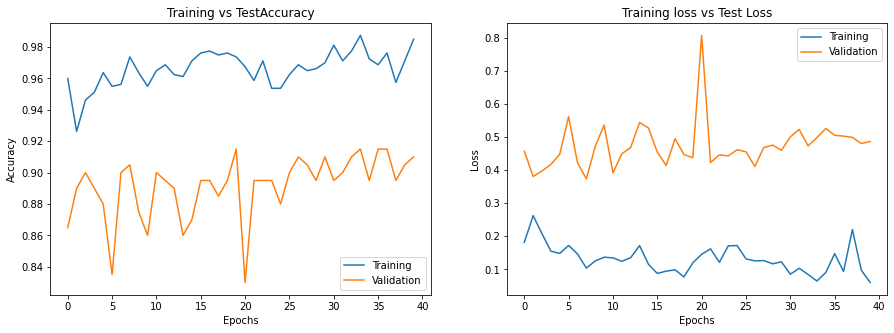

In [ ]:
generate_graph(xception_unscaled_flip)

##### Xception unscaled flip_rotate

In [ ]:
xception_flip_rotate.fit(train_ds_flip_rotate,validation_data=val_ds,epochs = 40, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1},callbacks = callbacks_xception)

Epoch 1/40
25/25 [==============================] - 18s 564ms/step - loss: 0.5283 - accuracy: 0.9087 - val_loss: 0.4511 - val_accuracy: 0.8800

Epoch 00001: saving model to sloan_xception/model-00001-0.52835-0.90875-0.45112-0.88000.h5
Epoch 2/40
25/25 [==============================] - 17s 569ms/step - loss: 0.4725 - accuracy: 0.9150 - val_loss: 0.7572 - val_accuracy: 0.7900

Epoch 00002: saving model to sloan_xception/model-00002-0.47248-0.91500-0.75723-0.79000.h5
Epoch 3/40
25/25 [==============================] - 16s 547ms/step - loss: 0.3129 - accuracy: 0.9250 - val_loss: 0.5010 - val_accuracy: 0.8500

Epoch 00003: saving model to sloan_xception/model-00003-0.31287-0.92500-0.50099-0.85000.h5
Epoch 4/40
25/25 [==============================] - 16s 551ms/step - loss: 0.2864 - accuracy: 0.9275 - val_loss: 0.4756 - val_accuracy: 0.8400

Epoch 00004: saving model to sloan_xception/model-00004-0.28641-0.92750-0.47562-0.84000.h5
Epoch 5/40
25/25 [==============================] - 17s 580m

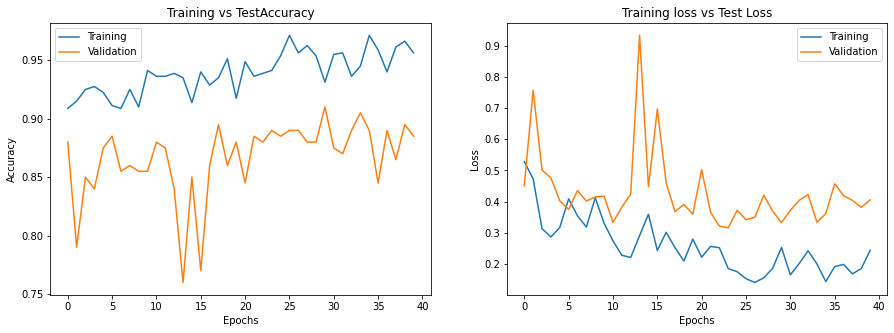

In [ ]:
generate_graph(xception_flip_rotate)

##### Xception crop flip

In [ ]:
xception_unscaled_crop_flip.fit(train_ds_crop_flip,validation_data=val_ds_normal_crop,epochs = 40, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = callbacks_xception)

Epoch 1/40
25/25 [==============================] - 16s 534ms/step - loss: 0.1426 - accuracy: 0.9700 - val_loss: 0.3175 - val_accuracy: 0.9250

Epoch 00001: saving model to sloan_xception/model-00001-0.14256-0.97000-0.31753-0.92500.h5
Epoch 2/40
25/25 [==============================] - 16s 546ms/step - loss: 0.2355 - accuracy: 0.9463 - val_loss: 0.3323 - val_accuracy: 0.9200

Epoch 00002: saving model to sloan_xception/model-00002-0.23553-0.94625-0.33231-0.92000.h5
Epoch 3/40
25/25 [==============================] - 16s 542ms/step - loss: 0.1467 - accuracy: 0.9525 - val_loss: 0.2861 - val_accuracy: 0.9200

Epoch 00003: saving model to sloan_xception/model-00003-0.14667-0.95250-0.28612-0.92000.h5
Epoch 4/40
25/25 [==============================] - 16s 538ms/step - loss: 0.1205 - accuracy: 0.9712 - val_loss: 0.3235 - val_accuracy: 0.9150

Epoch 00004: saving model to sloan_xception/model-00004-0.12048-0.97125-0.32348-0.91500.h5
Epoch 5/40
25/25 [==============================] - 16s 541m

##### Xception crop flip rotate


In [ ]:
xception_unscaled_crop_flip_rotate.fit(train_ds_crop_flip_rotate,validation_data=val_ds_normal_crop,epochs = 40, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1})

Epoch 1/40
25/25 [==============================] - 41s 1s/step - loss: 1.2580 - accuracy: 0.7763 - val_loss: 0.8979 - val_accuracy: 0.8600
Epoch 2/40
25/25 [==============================] - 38s 1s/step - loss: 0.5864 - accuracy: 0.8875 - val_loss: 0.9275 - val_accuracy: 0.7250
Epoch 3/40
25/25 [==============================] - 38s 1s/step - loss: 0.5392 - accuracy: 0.8763 - val_loss: 0.9296 - val_accuracy: 0.7000
Epoch 4/40
25/25 [==============================] - 38s 1s/step - loss: 0.4655 - accuracy: 0.9137 - val_loss: 1.0120 - val_accuracy: 0.6600
Epoch 5/40
25/25 [==============================] - 38s 1s/step - loss: 0.3746 - accuracy: 0.9225 - val_loss: 0.5071 - val_accuracy: 0.8250
Epoch 6/40
25/25 [==============================] - 39s 1s/step - loss: 0.4157 - accuracy: 0.8925 - val_loss: 0.4728 - val_accuracy: 0.8400
Epoch 7/40
25/25 [==============================] - 38s 1s/step - loss: 0.4435 - accuracy: 0.9025 - val_loss: 0.6295 - val_accuracy: 0.7800
Epoch 8/40
25/25 [==

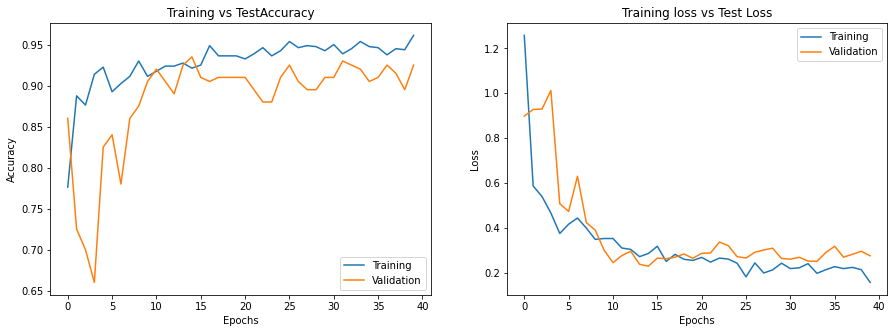

In [ ]:
generate_graph(xception_unscaled_crop_flip_rotate)

In [ ]:
xception_unscaled_crop_flip_rotate.fit(train_ds_crop_flip_rotate,validation_data=val_ds_normal_crop,epochs = 40, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1},callbacks = callbacks_xception)

Epoch 1/40
25/25 [==============================] - 38s 1s/step - loss: 0.2278 - accuracy: 0.9488 - val_loss: 0.3850 - val_accuracy: 0.8550

Epoch 00001: saving model to sloan_xception/model-00001-0.22777-0.94875-0.38505-0.85500.h5
Epoch 2/40
25/25 [==============================] - 39s 1s/step - loss: 0.2349 - accuracy: 0.9425 - val_loss: 0.2504 - val_accuracy: 0.9300

Epoch 00002: saving model to sloan_xception/model-00002-0.23489-0.94250-0.25042-0.93000.h5
Epoch 3/40
25/25 [==============================] - 21s 703ms/step - loss: 0.1663 - accuracy: 0.9488 - val_loss: 0.2850 - val_accuracy: 0.9100

Epoch 00003: saving model to sloan_xception/model-00003-0.16634-0.94875-0.28504-0.91000.h5
Epoch 4/40
25/25 [==============================] - 21s 702ms/step - loss: 0.2359 - accuracy: 0.9488 - val_loss: 0.3343 - val_accuracy: 0.9000

Epoch 00004: saving model to sloan_xception/model-00004-0.23592-0.94875-0.33431-0.90000.h5
Epoch 5/40
25/25 [==============================] - 21s 699ms/step

##### Preprocessing  - Xception crop flip rotate


In [ ]:
# train_ds_normal_crop = prepare_dataset_normal_crop(train_ds_cropped) 
# val_ds_normal_crop = prepare_dataset_normal_crop(val_ds_cropped, training = False)
xception_model.fit(train_ds_normal_crop, validation_data = val_ds_normal_crop, epochs = 40, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = callbacks_xception)



Epoch 1/20
25/25 [==============================] - 19s 636ms/step - loss: 0.7834 - accuracy: 0.7650 - val_loss: 0.5653 - val_accuracy: 0.7350

Epoch 00001: saving model to sloan_xception/model-00001-0.78336-0.76500-0.56531-0.73500.h5
Epoch 2/20
25/25 [==============================] - 19s 642ms/step - loss: 0.8176 - accuracy: 0.7387 - val_loss: 0.5602 - val_accuracy: 0.7350

Epoch 00002: saving model to sloan_xception/model-00002-0.81760-0.73875-0.56020-0.73500.h5
Epoch 3/20
25/25 [==============================] - 19s 636ms/step - loss: 0.7799 - accuracy: 0.7563 - val_loss: 0.5486 - val_accuracy: 0.7400

Epoch 00003: saving model to sloan_xception/model-00003-0.77986-0.75625-0.54858-0.74000.h5
Epoch 4/20
25/25 [==============================] - 19s 633ms/step - loss: 0.7491 - accuracy: 0.7700 - val_loss: 0.5359 - val_accuracy: 0.7500

Epoch 00004: saving model to sloan_xception/model-00004-0.74906-0.77000-0.53587-0.75000.h5
Epoch 5/20
25/25 [==============================] - 19s 630m

##### Model Evaluation

In [ ]:
train_ds_normal_crop = prepare_dataset_normal_crop(train_ds_cropped) 
val_ds_normal_crop = prepare_dataset_normal_crop(val_ds_cropped, training = False)

xception_scaled = load_model('./sloan_xception/Xception_scaled_00024-0.50248-0.87875-0.39955-0.84000.h5')
xception_unscaled = load_model('./sloan_xception/Xception_unscaled_0.18934-0.95875-0.45550-0.90500.h5') 
xception_unscaled_flip = load_model('./sloan_xception/Xception_unscaled_model_flip-00036-0.14-0.9687-0.50-0.91500.h5')
xception_unscaled_flip_rotate = load_model('./sloan_xception/Xception_unsclaed_flip_rot-00030-0.25264-0.93125-0.33230-0.91000.h5')
xception_unscaled_crop_flip = load_model('./sloan_xception/Xception_crop_flip0.1351-0.9687-0.2933-0.9300.h5')
xception_unscaled_crop_flip_rotate = load_model('./sloan_xception/Xception_crop_flip_rotate_0.21518-0.93875-0.24829-0.93500.h5')
xception_preprocessing_crop = load_model('./sloan_xception/Xception_preprocess_croposs_0.6720-0.7875_0.4998-7950.h5')


metrics = Metrics(xception_scaled,val_ds_scaled)
print(metrics.calculate_scores())
print('---------------------------------------------------------------------------------------------------------------------')
metrics = Metrics(xception_unscaled,val_ds)
print(metrics.calculate_scores())
print('---------------------------------------------------------------------------------------------------------------------')
metrics = Metrics(xception_unscaled_flip,val_ds)
print(metrics.calculate_scores())
print('---------------------------------------------------------------------------------------------------------------------')
metrics = Metrics(xception_unscaled_flip_rotate,val_ds)
print(metrics.calculate_scores())
print('---------------------------------------------------------------------------------------------------------------------')
metrics = Metrics(xception_unscaled_crop_flip,val_ds_normal_crop)
print(metrics.calculate_scores())
print('---------------------------------------------------------------------------------------------------------------------')
metrics = Metrics(xception_unscaled_crop_flip_rotate,val_ds_normal_crop)
print(metrics.calculate_scores())
print('---------------------------------------------------------------------------------------------------------------------')
metrics = Metrics(xception_preprocessing_crop,val_ds_normal_crop)
print(metrics.calculate_scores())
print('---------------------------------------------------------------------------------------------------------------------')



calculating score.....
[[91  3  2]
 [ 0 11  6]
 [ 9 12 66]]
------------------------------------
              precision    recall  f1-score   support

         0.0       0.91      0.95      0.93        96
         1.0       0.42      0.65      0.51        17
         2.0       0.89      0.76      0.82        87

    accuracy                           0.84       200
   macro avg       0.74      0.78      0.75       200
weighted avg       0.86      0.84      0.85       200

None
---------------------------------------------------------------------------------------------------------------------
calculating score.....
[[93  0  3]
 [ 0 11  6]
 [ 1  9 77]]
------------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98        96
         1.0       0.55      0.65      0.59        17
         2.0       0.90      0.89      0.89        87

    accuracy                           0.91       200
   macro avg       0.81      0

#### Efficient Net

##### Model building

In [ ]:
base_model_effnet = tf.keras.applications.EfficientNetB2(
    include_top=False,
    weights="imagenet",    
    input_shape=(img_height, img_width, channels),
    pooling='max',
    classes=3,
)
layer_count  = len(base_model_effnet.layers)
print(f'There are a total of {layer_count} layers in the EfficientNetB2 network')
# making the base layers non trainable or freezing
# 5%, 10%. 20% 30% 

break_point  = 330
for layer in base_model_effnet.layers[0:break_point]:
    layer.trainable = False
for layer in base_model_effnet.layers[break_point:]:
    layer.trainable = True

# please note higher the break point ; lesser the trainable layers lesser is the over fitting -> high breakpoint -> less over fitting 
base_model_effnet.inputs
input_layer = base_model_effnet.inputs

# Building a functional model
output = base_model_effnet.output
x = Dense(num_classes, activation  = 'softmax')(output)
effnet_model = Model(inputs = input_layer, outputs = x)
effnet_model.summary()
effnet_model.compile(optimizer = optimizers.Adam(lr=1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'],)
class_weight = {0:1.13, 1:8.03, 2:1}


31793152/31790344 [==============================] - 0s 0us/step
There are a total of 340 layers in the EfficientNetB2 network
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 512, 512, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 512, 512, 3)  7           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 513, 513, 3)  0          

##### efficient net unscaled

In [ ]:
effnet_model.fit(train_ds,validation_data=val_ds,epochs = 40, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = callbacks_efficient)

Epoch 1/40
25/25 [==============================] - 12s 407ms/step - loss: 1.2636 - accuracy: 0.8425 - val_loss: 1.0022 - val_accuracy: 0.7950

Epoch 00001: saving model to sloan_efficient/model-00001-1.26-0.84-1.00-0.80.h5
Epoch 2/40
25/25 [==============================] - 12s 414ms/step - loss: 0.4338 - accuracy: 0.9013 - val_loss: 0.4531 - val_accuracy: 0.8850

Epoch 00002: saving model to sloan_efficient/model-00002-0.43-0.90-0.45-0.88.h5
Epoch 3/40
25/25 [==============================] - 12s 414ms/step - loss: 0.3661 - accuracy: 0.9275 - val_loss: 0.4791 - val_accuracy: 0.8800

Epoch 00003: saving model to sloan_efficient/model-00003-0.37-0.93-0.48-0.88.h5
Epoch 4/40
25/25 [==============================] - 12s 414ms/step - loss: 0.4579 - accuracy: 0.9125 - val_loss: 0.4672 - val_accuracy: 0.8800

Epoch 00004: saving model to sloan_efficient/model-00004-0.46-0.91-0.47-0.88.h5
Epoch 5/40
25/25 [==============================] - 12s 411ms/step - loss: 0.4095 - accuracy: 0.9100 - v

##### efficient net scaled

In [ ]:
effnet_model.fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 15, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = callbacks_efficient)

Epoch 1/15
25/25 [==============================] - 11s 385ms/step - loss: 2.9410 - accuracy: 0.3512 - val_loss: 2.4867 - val_accuracy: 0.0850

Epoch 00001: saving model to sloan_efficient/model-00001-2.94-0.35-2.49-0.09.h5
Epoch 2/15
25/25 [==============================] - 11s 386ms/step - loss: 2.8590 - accuracy: 0.3450 - val_loss: 3.4268 - val_accuracy: 0.4350

Epoch 00002: saving model to sloan_efficient/model-00002-2.86-0.34-3.43-0.44.h5
Epoch 3/15
25/25 [==============================] - 11s 384ms/step - loss: 2.9926 - accuracy: 0.3837 - val_loss: 1.6872 - val_accuracy: 0.4350

Epoch 00003: saving model to sloan_efficient/model-00003-2.99-0.38-1.69-0.44.h5
Epoch 4/15
25/25 [==============================] - 11s 385ms/step - loss: 2.9290 - accuracy: 0.3038 - val_loss: 3.5419 - val_accuracy: 0.4350

Epoch 00004: saving model to sloan_efficient/model-00004-2.93-0.30-3.54-0.44.h5
Epoch 5/15
25/25 [==============================] - 11s 387ms/step - loss: 2.7024 - accuracy: 0.3587 - v

##### Augmenation techniques

In [ ]:
train_ds_flip = prepare_dataset(train_ds, flip= True)
train_ds_flip_rotate = prepare_dataset(train_ds, flip_rotate = True)
train_ds_crop_flip = prepare_dataset_crop(train_ds_cropped, crop_flip = True)
train_ds_crop_flip_rotate = prepare_dataset_crop(train_ds_cropped, crop_flip_rotate = True)
val_ds_normal_crop = prepare_dataset_normal_crop(val_ds_cropped, training = False)

efficient_unscaled_flip = load_model('./sloan_efficient/Effnet_unscaled-0.55-0.91-0.49-0.90.h5')
efficient_unscaled_flip_rotate = load_model('./sloan_efficient/Effnet_unscaled-0.55-0.91-0.49-0.90.h5') 
efficient_unscaled_crop_flip = load_model('./sloan_efficient/Effnet_unscaled-0.55-0.91-0.49-0.90.h5')
efficient_unscaled_crop_flip_rotate = load_model('./sloan_efficient/Effnet_unscaled-0.55-0.91-0.49-0.90.h5')

##### Efficient unscaled flip

In [ ]:
efficient_unscaled_flip.fit(train_ds_flip,validation_data=val_ds, epochs = 40, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = callbacks_efficient)


Epoch 1/40
25/25 [==============================] - 17s 460ms/step - loss: 0.6751 - accuracy: 0.8675 - val_loss: 0.6340 - val_accuracy: 0.8800

Epoch 00001: saving model to sloan_efficient/model-00001-0.68-0.8675-0.63-0.8800.h5
Epoch 2/40
25/25 [==============================] - 12s 403ms/step - loss: 0.9782 - accuracy: 0.8537 - val_loss: 1.7031 - val_accuracy: 0.7750

Epoch 00002: saving model to sloan_efficient/model-00002-0.98-0.8537-1.70-0.7750.h5
Epoch 3/40
25/25 [==============================] - 11s 399ms/step - loss: 1.0983 - accuracy: 0.8487 - val_loss: 0.7066 - val_accuracy: 0.8900

Epoch 00003: saving model to sloan_efficient/model-00003-1.10-0.8487-0.71-0.8900.h5
Epoch 4/40
25/25 [==============================] - 12s 403ms/step - loss: 0.6836 - accuracy: 0.8825 - val_loss: 1.2376 - val_accuracy: 0.8050

Epoch 00004: saving model to sloan_efficient/model-00004-0.68-0.8825-1.24-0.8050.h5
Epoch 5/40
25/25 [==============================] - 12s 399ms/step - loss: 1.0654 - accu

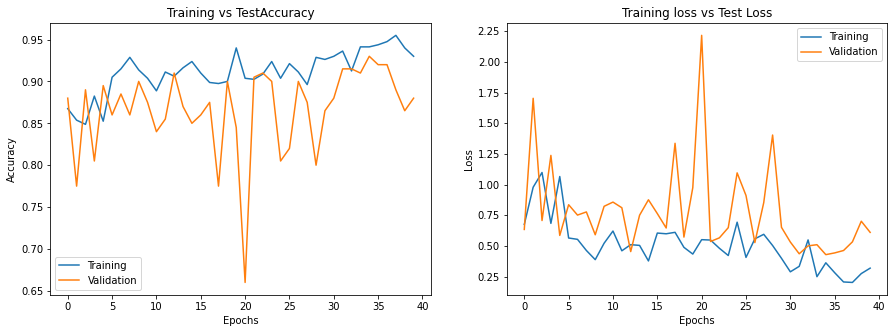

In [ ]:
generate_graph(efficient_unscaled_flip)

##### Efficient unscaled flip rotate

In [ ]:
efficient_unscaled_flip_rotate.fit(train_ds_flip_rotate,validation_data=val_ds, epochs = 30, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = callbacks_efficient)


Epoch 1/30
25/25 [==============================] - 22s 620ms/step - loss: 0.9538 - accuracy: 0.8550 - val_loss: 1.1315 - val_accuracy: 0.8000

Epoch 00001: saving model to sloan_efficient/model-00001-0.95-0.8550-1.13-0.8000.h5
Epoch 2/30
25/25 [==============================] - 16s 549ms/step - loss: 1.2355 - accuracy: 0.8388 - val_loss: 1.0797 - val_accuracy: 0.8100

Epoch 00002: saving model to sloan_efficient/model-00002-1.24-0.8388-1.08-0.8100.h5
Epoch 3/30
25/25 [==============================] - 16s 546ms/step - loss: 1.1761 - accuracy: 0.8712 - val_loss: 1.6337 - val_accuracy: 0.7500

Epoch 00003: saving model to sloan_efficient/model-00003-1.18-0.8712-1.63-0.7500.h5
Epoch 4/30
25/25 [==============================] - 16s 540ms/step - loss: 1.2402 - accuracy: 0.8175 - val_loss: 0.3579 - val_accuracy: 0.9200

Epoch 00004: saving model to sloan_efficient/model-00004-1.24-0.8175-0.36-0.9200.h5
Epoch 5/30
25/25 [==============================] - 16s 547ms/step - loss: 0.9378 - accu

##### Efficient unscaled crop flip

In [ ]:
efficient_unscaled_crop_flip.fit(train_ds_crop_flip,validation_data=val_ds_normal_crop, epochs = 30, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1})


Epoch 1/30
25/25 [==============================] - 27s 848ms/step - loss: 6.8485 - accuracy: 0.5863 - val_loss: 5.8661 - val_accuracy: 0.4250
Epoch 2/30
25/25 [==============================] - 22s 774ms/step - loss: 3.7124 - accuracy: 0.7462 - val_loss: 2.0484 - val_accuracy: 0.7600
Epoch 3/30
25/25 [==============================] - 22s 786ms/step - loss: 2.6836 - accuracy: 0.7850 - val_loss: 0.7679 - val_accuracy: 0.8900
Epoch 4/30
25/25 [==============================] - 22s 778ms/step - loss: 2.4572 - accuracy: 0.7875 - val_loss: 0.6467 - val_accuracy: 0.8700
Epoch 5/30
25/25 [==============================] - 22s 782ms/step - loss: 1.4139 - accuracy: 0.8275 - val_loss: 1.2832 - val_accuracy: 0.8200
Epoch 6/30
25/25 [==============================] - 22s 782ms/step - loss: 1.1145 - accuracy: 0.8625 - val_loss: 0.8571 - val_accuracy: 0.8650
Epoch 7/30
25/25 [==============================] - 22s 784ms/step - loss: 0.8778 - accuracy: 0.8712 - val_loss: 0.6614 - val_accuracy: 0.8650

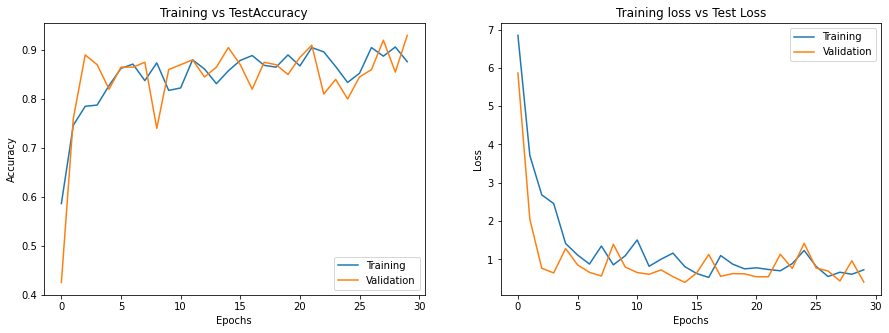

In [ ]:
generate_graph(efficient_unscaled_crop_flip)

In [ ]:
efficient_unscaled_crop_flip.fit(train_ds_crop_flip,validation_data=val_ds_normal_crop, epochs = 30, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = callbacks_efficient)


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/30
25/25 [==============================] - 151s 4s/step - loss: 4.0241 - accuracy: 0.6687 - val_loss: 1.4895 - val_accuracy: 0.8350

Epoch 00001: saving model to sloan_efficient/model-00001-4.02-0.6687-1.49-0.8350.h5
Epoch 2/30
25/25 [==============================] - 20s 669ms/step - loss: 3.2663 - accuracy: 0.7063 - val_loss: 0.5659 - val_accuracy: 0.9100

Epoch 00002: saving model to sloan_efficient/model-00002-3.27-0.7063-0.57-0.9100.h5
Epoch 3/30
25/25 [==============================] - 20s 670ms/step - loss: 2.1248 - accuracy: 0.7675 - val_loss: 1.5306 - val_accuracy: 0.7850

Epoch 00003: saving model to sloan_efficient/model-00003-2.12-0.7675-1.53-0.7850.h5
Epoch 4/30
25/25 [==============================] - 20s 659ms/step - loss: 2.2764 - accuracy: 0.7763 - val_loss: 1.1234 - val_accuracy: 0.8300

Epoch 00004: saving model to sloan_e

##### Efficient unscaled crop flip rotate

In [ ]:
efficient_unscaled_crop_flip_rotate.fit(train_ds_crop_flip_rotate,validation_data=val_ds_normal_crop, epochs = 30, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = callbacks_efficient)


Epoch 1/30
25/25 [==============================] - 33s 946ms/step - loss: 3.0900 - accuracy: 0.6450 - val_loss: 3.1085 - val_accuracy: 0.5600

Epoch 00001: saving model to sloan_efficient/model-00001-3.09-0.6450-3.11-0.5600.h5
Epoch 2/30
25/25 [==============================] - 26s 873ms/step - loss: 2.5834 - accuracy: 0.7212 - val_loss: 3.5645 - val_accuracy: 0.4400

Epoch 00002: saving model to sloan_efficient/model-00002-2.58-0.7212-3.56-0.4400.h5
Epoch 3/30
25/25 [==============================] - 26s 863ms/step - loss: 3.4907 - accuracy: 0.7337 - val_loss: 2.3470 - val_accuracy: 0.6850

Epoch 00003: saving model to sloan_efficient/model-00003-3.49-0.7337-2.35-0.6850.h5
Epoch 4/30
25/25 [==============================] - 26s 874ms/step - loss: 3.1626 - accuracy: 0.7525 - val_loss: 4.0332 - val_accuracy: 0.5850

Epoch 00004: saving model to sloan_efficient/model-00004-3.16-0.7525-4.03-0.5850.h5
Epoch 5/30
25/25 [==============================] - 26s 866ms/step - loss: 3.3598 - accu

##### Efficient net preprocess crop

In [ ]:
train_ds_normal_crop = prepare_dataset_normal_crop(train_ds_cropped) 
val_ds_normal_crop = prepare_dataset_normal_crop(val_ds_cropped, training = False)
effnet_model.fit(train_ds_normal_crop, validation_data = val_ds_normal_crop, epochs = 40, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = callbacks_efficient)


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/40
25/25 [==============================] - 31s 630ms/step - loss: 13.2921 - accuracy: 0.4325 - val_loss: 0.9010 - val_accuracy: 0.6200

Epoch 00001: saving model to sloan_efficient/model-00001-13.29-0.4325-0.90-0.6200.h5
Epoch 2/40
25/25 [==============================] - 18s 598ms/step - loss: 2.4853 - accuracy: 0.6400 - val_loss: 0.7998 - val_accuracy: 0.6400

Epoch 00002: saving model to sloan_efficient/model-00002-2.49-0.6400-0.80-0.6400.h5
Epoch 3/40
25/25 [==============================] - 18s 594ms/step - loss: 1.4679 - accuracy: 0.7538 - val_loss: 1.4077 - val_accuracy: 0.6000

Epoch 00003: saving model to sloan_efficient/model-00003-1.47-0.7538-1.41-0.6000.h5
Epoch 4/40
25/25 [==============================] - 18s 597ms/step - loss: 1.2738 - accuracy: 0.7600 - val_loss: 1.0891 - val_accuracy: 0.6350

Epoch 00004: saving model to slo

##### Model Evaluation

In [ ]:
val_ds_normal_crop = prepare_dataset_normal_crop(val_ds_cropped, training = False)

effnet_scaled = load_model('./sloan_efficient/Effnet_scaled-4.33-0.40-2.95-0.44.h5')
effnet_unscaled = load_model('./sloan_efficient/Effnet_unscaled-0.55-0.91-0.49-0.90.h5') 
effnet_unscaled_flip = load_model('./sloan_efficient/Eff_unscaled_flip-0.36-0.9413-0.43-0.9300.h5')
effnet_unscaled_flip_rotate = load_model('./sloan_efficient/Eff_unscaled_flip_rotate-0.61-0.9000-0.42-0.9000.h5')
effnet_unscaled_crop_flip = load_model('./sloan_efficient/Effnet_unscaled_crop_flip-0.93-0.8775-0.42-0.9450.h5')
effnet_unscaled_crop_flip_rotate = load_model('./sloan_efficient/effnet_unscaled_crop_flip_rotate-0.94-0.8462-0.48-0.9300.h5')
effnet_preprocessing_crop = load_model('./sloan_efficient/effnet_crop_preprocessed-0.65-0.8825-0.40-0.9200.h5')


metrics = Metrics(effnet_scaled,val_ds_scaled)
print(metrics.calculate_scores())
print('---------------------------------------------------------------------------------------------------------------------')
metrics = Metrics(effnet_unscaled,val_ds)
print(metrics.calculate_scores())
print('---------------------------------------------------------------------------------------------------------------------')
metrics = Metrics(effnet_unscaled_flip,val_ds)
print(metrics.calculate_scores())
print('---------------------------------------------------------------------------------------------------------------------')
metrics = Metrics(effnet_unscaled_flip_rotate,val_ds)
print(metrics.calculate_scores())
print('---------------------------------------------------------------------------------------------------------------------')
metrics = Metrics(effnet_unscaled_crop_flip,val_ds_normal_crop)
print(metrics.calculate_scores())
print('---------------------------------------------------------------------------------------------------------------------')
metrics = Metrics(effnet_unscaled_crop_flip_rotate,val_ds_normal_crop)
print(metrics.calculate_scores())
print('---------------------------------------------------------------------------------------------------------------------')
metrics = Metrics(effnet_preprocessing_crop,val_ds_normal_crop)
print(metrics.calculate_scores())
print('---------------------------------------------------------------------------------------------------------------------')

calculating score.....
[[ 0  0 96]
 [ 0  0 17]
 [ 0  0 87]]
------------------------------------
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        96
         1.0       0.00      0.00      0.00        17
         2.0       0.43      1.00      0.61        87

    accuracy                           0.43       200
   macro avg       0.14      0.33      0.20       200
weighted avg       0.19      0.43      0.26       200

None
---------------------------------------------------------------------------------------------------------------------
calculating score.....
[[90  1  5]
 [ 0 11  6]
 [ 1  6 80]]
------------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.94      0.96        96
         1.0       0.61      0.65      0.63        17
         2.0       0.88      0.92      0.90        87

    accuracy                           0.91       200
   macro avg       0.83      0

##### Densenet 121

In [ ]:
base_model_densenet = tf.keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",    
    input_shape=(img_height, img_width, channels),
    pooling='max',
    classes=3,
)
layer_count  = len(base_model_densenet.layers)
print(f'There are a total of {layer_count} layers in the Densenet121 network')

# making the base layers non trainable or freezing
#1,2,3,4,5,6,.....430
# freez1-429.... 430
# free1-428... 429,430
#freeze1-427..428,429,430

break_point  = 428
for layer in base_model_densenet.layers[0:break_point]:
    layer.trainable = False
for layer in base_model_densenet.layers[break_point:]:
    layer.trainable = True

# please note higher the break point ; lesser the trainable layers lesser is the over fitting -> high breakpoint -> less over fitting 
base_model_densenet.inputs
input_layer = base_model_densenet.inputs
# Building a functional model

output = base_model_densenet.output
print(output)
x = Dense(num_classes, activation  = 'softmax')(output)

densenet_model = Model(inputs = input_layer, outputs = x)
densenet_model.summary()
densenet_model.compile(optimizer = optimizers.Adam(lr=1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])

29089792/29084464 [==============================] - 1s 0us/step
There are a total of 428 layers in the Densenet121 network
KerasTensor(type_spec=TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None), name='max_pool/Max:0', description="created by layer 'max_pool'")
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 518, 518, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 256, 256, 64) 9408        zero_padding2d[0][0]             
_________________

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.785422 to fit



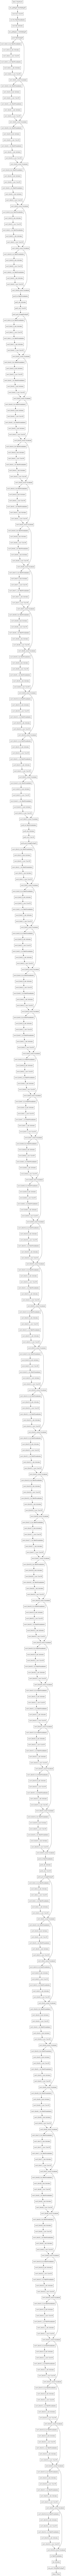

In [ ]:
keras.utils.plot_model(densenet_model)

##### Densenet without class balancing

In [ ]:
dense_model.fit(train_ds,validation_data=val_ds,epochs = 40, verbose = 1, workers = 3,callbacks = callbacks_dense)

Epoch 1/40
25/25 [==============================] - 94s 2s/step - loss: 4.8745 - accuracy: 0.2375 - val_loss: 4.7399 - val_accuracy: 0.3150

Epoch 00001: saving model to sloan_dense/model-00001-4.87-0.2375-4.74-0.3150.h5
Epoch 2/40
25/25 [==============================] - 14s 515ms/step - loss: 3.8640 - accuracy: 0.2962 - val_loss: 3.6376 - val_accuracy: 0.2950

Epoch 00002: saving model to sloan_dense/model-00002-3.86-0.2962-3.64-0.2950.h5
Epoch 3/40
25/25 [==============================] - 14s 515ms/step - loss: 3.0170 - accuracy: 0.3200 - val_loss: 2.9390 - val_accuracy: 0.3450

Epoch 00003: saving model to sloan_dense/model-00003-3.02-0.3200-2.94-0.3450.h5
Epoch 4/40
25/25 [==============================] - 14s 513ms/step - loss: 2.3455 - accuracy: 0.3775 - val_loss: 2.3026 - val_accuracy: 0.3950

Epoch 00004: saving model to sloan_dense/model-00004-2.35-0.3775-2.30-0.3950.h5
Epoch 5/40
25/25 [==============================] - 14s 512ms/step - loss: 1.8780 - accuracy: 0.4712 - val_

In [ ]:
metrics = Metrics(densenet_model,val_ds)
print(metrics.calculate_scores())
print('---------------------------------------------------------------------------------------------------------------------')

calculating score.....
[[85  2  9]
 [ 4  5  8]
 [ 4  5 78]]
------------------------------------
              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90        96
         1.0       0.42      0.29      0.34        17
         2.0       0.82      0.90      0.86        87

    accuracy                           0.84       200
   macro avg       0.72      0.69      0.70       200
weighted avg       0.83      0.84      0.83       200

None
---------------------------------------------------------------------------------------------------------------------


##### densenet without scaling

In [ ]:
densenet_model.fit(train_ds,validation_data=val_ds,epochs = 40, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = callbacks_dense)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/40
25/25 [==============================] - 20s 460ms/step - loss: 6.8324 - accuracy: 0.2100 - val_loss: 4.3144 - val_accuracy: 0.2250

Epoch 00001: saving model to sloan_dense/model-00001-6.83-0.2100-4.31-0.2250.h5
Epoch 2/40
25/25 [==============================] - 11s 377ms/step - loss: 5.6543 - accuracy: 0.2612 - val_loss: 3.5993 - val_accuracy: 0.2400

Epoch 00002: saving model to sloan_dense/model-00002-5.65-0.2612-3.60-0.2400.h5
Epoch 3/40
25/25 [==============================] - 11s 383ms/step - loss: 4.7375 - accuracy: 0.2937 - val_loss: 3.2093 - val_accuracy: 0.2950

Epoch 00003: saving model to sloan_dense/model-00003-4.74-0.2937-3.21-0.2950.h5
Epoch 4/40
25/25 [==============================] - 11s 380ms/step - loss: 4.0245 - accuracy: 0.3650 - val_loss: 2.7328 - val_accuracy: 0.3500

Epoch 00004: saving model to sloan_dense/model

In [ ]:
metrics = Metrics(densenet_model,val_ds)
print(metrics.calculate_scores())
print('---------------------------------------------------------------------------------------------------------------------')

calculating score.....
[[84  3  9]
 [ 1  9  7]
 [ 7 13 67]]
------------------------------------
              precision    recall  f1-score   support

         0.0       0.91      0.88      0.89        96
         1.0       0.36      0.53      0.43        17
         2.0       0.81      0.77      0.79        87

    accuracy                           0.80       200
   macro avg       0.69      0.72      0.70       200
weighted avg       0.82      0.80      0.81       200

None
---------------------------------------------------------------------------------------------------------------------


##### Densenet with scale

In [ ]:
densenet_model.fit(train_ds_scaled,validation_data=val_ds_scaled,epochs = 40, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = callbacks_dense)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/40
25/25 [==============================] - 86s 2s/step - loss: 5.1717 - accuracy: 0.4475 - val_loss: 1.8372 - val_accuracy: 0.3900

Epoch 00001: saving model to sloan_dense/model-00001-5.17-0.4475-1.84-0.3900.h5
Epoch 2/40
25/25 [==============================] - 10s 351ms/step - loss: 3.1863 - accuracy: 0.3750 - val_loss: 1.6543 - val_accuracy: 0.3800

Epoch 00002: saving model to sloan_dense/model-00002-3.19-0.3750-1.65-0.3800.h5
Epoch 3/40
25/25 [==============================] - 10s 350ms/step - loss: 2.7202 - accuracy: 0.3913 - val_loss: 1.4601 - val_accuracy: 0.4250

Epoch 00003: saving model to sloan_dense/model-00003-2.72-0.3913-1.46-0.4250.h5
Epoch 4/40
25/25 [==============================] - 10s 350ms/step - loss: 2.4120 - accuracy: 0.4450 - val_loss: 1.3066 - val_accuracy: 0.5000

Epoch 00004: saving model to sloan_dense/model-00

In [ ]:
dense_scaled = load_model('./sloan_dense/Dense_scale-0.69-0.8250-0.52-0.8100.h5') 
metrics = Metrics(dense_scaled,val_ds_scaled)
print(metrics.calculate_scores())
print('---------------------------------------------------------------------------------------------------------------------')

calculating score.....
[[89  2  5]
 [ 1 11  5]
 [ 7 18 62]]
------------------------------------
              precision    recall  f1-score   support

         0.0       0.92      0.93      0.92        96
         1.0       0.35      0.65      0.46        17
         2.0       0.86      0.71      0.78        87

    accuracy                           0.81       200
   macro avg       0.71      0.76      0.72       200
weighted avg       0.85      0.81      0.82       200

None
---------------------------------------------------------------------------------------------------------------------


##### Augmentation techniques


In [ ]:
train_ds_scaled_flip = prepare_dataset(train_ds_scaled, flip= True)
train_ds_scaled_flip_rotate = prepare_dataset(train_ds_scaled, flip_rotate = True)
train_ds_scaled_crop_flip = prepare_dataset_crop(train_ds_scaled_cropped, crop_flip = True)
train_ds_scaled_crop_flip_rotate = prepare_dataset_crop(train_ds_scaled_cropped, crop_flip_rotate = True)

train_ds_normal_crop = prepare_dataset_normal_crop(train_ds_scaled_cropped, training = True) 
val_ds_normal_crop = prepare_dataset_normal_crop(val_ds_scaled_cropped, training = False)

dense_scaled_flip = load_model('./sloan_dense/Dense_scale-0.69-0.8250-0.52-0.8100.h5')
dense_scaled_flip_rotate = load_model('./sloan_dense/Dense_scale-0.69-0.8250-0.52-0.8100.h5') 
dense_scaled_crop_flip = load_model('./sloan_dense/Dense_scale-0.69-0.8250-0.52-0.8100.h5') 
dense_scaled_crop_flip_rotate = load_model('./sloan_dense/Dense_scale-0.69-0.8250-0.52-0.8100.h5') 

##### Dense scaled flip

In [ ]:
dense_scaled_flip.fit(train_ds_scaled_flip,validation_data=val_ds_scaled,epochs = 40, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1})

Epoch 1/40
25/25 [==============================] - 19s 533ms/step - loss: 0.7075 - accuracy: 0.8363 - val_loss: 0.5704 - val_accuracy: 0.7750
Epoch 2/40
25/25 [==============================] - 14s 484ms/step - loss: 0.7224 - accuracy: 0.7962 - val_loss: 0.5157 - val_accuracy: 0.8000
Epoch 3/40
25/25 [==============================] - 14s 486ms/step - loss: 0.7156 - accuracy: 0.8413 - val_loss: 0.5895 - val_accuracy: 0.7800
Epoch 4/40
25/25 [==============================] - 14s 489ms/step - loss: 0.6694 - accuracy: 0.8288 - val_loss: 0.5169 - val_accuracy: 0.7900
Epoch 5/40
25/25 [==============================] - 14s 479ms/step - loss: 0.6925 - accuracy: 0.8338 - val_loss: 0.5205 - val_accuracy: 0.7950
Epoch 6/40
25/25 [==============================] - 14s 486ms/step - loss: 0.6527 - accuracy: 0.8163 - val_loss: 0.5072 - val_accuracy: 0.7950
Epoch 7/40
25/25 [==============================] - 14s 487ms/step - loss: 0.6812 - accuracy: 0.8487 - val_loss: 0.5265 - val_accuracy: 0.8000

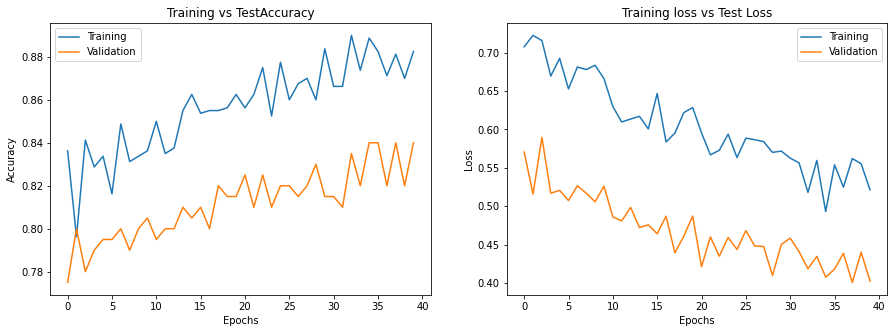

In [ ]:
generate_graph(dense_scaled_flip)

In [ ]:
dense_scaled_flip.fit(train_ds_scaled_flip,validation_data=val_ds_scaled,epochs = 40, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = callbacks_dense)

Epoch 1/40
25/25 [==============================] - 14s 390ms/step - loss: 0.7504 - accuracy: 0.8338 - val_loss: 0.5467 - val_accuracy: 0.7750

Epoch 00001: saving model to sloan_dense/model-00001-0.75-0.8338-0.55-0.7750.h5
Epoch 2/40
25/25 [==============================] - 10s 325ms/step - loss: 0.6854 - accuracy: 0.8375 - val_loss: 0.5118 - val_accuracy: 0.8050

Epoch 00002: saving model to sloan_dense/model-00002-0.69-0.8375-0.51-0.8050.h5
Epoch 3/40
25/25 [==============================] - 10s 326ms/step - loss: 0.6996 - accuracy: 0.8250 - val_loss: 0.5497 - val_accuracy: 0.7800

Epoch 00003: saving model to sloan_dense/model-00003-0.70-0.8250-0.55-0.7800.h5
Epoch 4/40
25/25 [==============================] - 10s 333ms/step - loss: 0.6715 - accuracy: 0.8413 - val_loss: 0.5307 - val_accuracy: 0.7850

Epoch 00004: saving model to sloan_dense/model-00004-0.67-0.8413-0.53-0.7850.h5
Epoch 5/40
25/25 [==============================] - 10s 326ms/step - loss: 0.7026 - accuracy: 0.8238 - v

In [ ]:
dense_scaled_flipped_model = load_model('./sloan_dense/dense_scaled_flip-0.51-0.8863-0.38-0.8500.h5') 
metrics = Metrics(dense_scaled_flipped_model,val_ds_scaled)
print(metrics.calculate_scores())
print('---------------------------------------------------------------------------------------------------------------------')

calculating score.....
[[89  3  4]
 [ 1  9  7]
 [ 1 14 72]]
------------------------------------
              precision    recall  f1-score   support

         0.0       0.98      0.93      0.95        96
         1.0       0.35      0.53      0.42        17
         2.0       0.87      0.83      0.85        87

    accuracy                           0.85       200
   macro avg       0.73      0.76      0.74       200
weighted avg       0.88      0.85      0.86       200

None
---------------------------------------------------------------------------------------------------------------------


##### Dense Scaled flip rotate

In [ ]:
dense_scaled_flip_rotate.fit(train_ds_scaled_flip_rotate,validation_data=val_ds_scaled,epochs = 40, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = callbacks_dense)

Epoch 1/40
25/25 [==============================] - 21s 626ms/step - loss: 0.7086 - accuracy: 0.8200 - val_loss: 0.5007 - val_accuracy: 0.8050

Epoch 00001: saving model to sloan_dense/model-00001-0.71-0.8200-0.50-0.8050.h5
Epoch 2/40
25/25 [==============================] - 17s 569ms/step - loss: 0.7479 - accuracy: 0.8150 - val_loss: 0.5632 - val_accuracy: 0.7700

Epoch 00002: saving model to sloan_dense/model-00002-0.75-0.8150-0.56-0.7700.h5
Epoch 3/40
25/25 [==============================] - 16s 563ms/step - loss: 0.7515 - accuracy: 0.8000 - val_loss: 0.5506 - val_accuracy: 0.7750

Epoch 00003: saving model to sloan_dense/model-00003-0.75-0.8000-0.55-0.7750.h5
Epoch 4/40
25/25 [==============================] - 17s 566ms/step - loss: 0.7665 - accuracy: 0.8300 - val_loss: 0.5460 - val_accuracy: 0.7800

Epoch 00004: saving model to sloan_dense/model-00004-0.77-0.8300-0.55-0.7800.h5
Epoch 5/40
25/25 [==============================] - 17s 563ms/step - loss: 0.7204 - accuracy: 0.8213 - v

In [ ]:
dense_scaled_flipped_rotate_model = load_model('./sloan_dense/dense_scaled_flip_rotate-0.61-0.8625-0.44-0.8250.h5') 
metrics = Metrics(dense_scaled_flipped_rotate_model,val_ds_scaled)
print(metrics.calculate_scores())
print('---------------------------------------------------------------------------------------------------------------------')

calculating score.....
[[90  2  4]
 [ 1 11  5]
 [ 4 19 64]]
------------------------------------
              precision    recall  f1-score   support

         0.0       0.95      0.94      0.94        96
         1.0       0.34      0.65      0.45        17
         2.0       0.88      0.74      0.80        87

    accuracy                           0.82       200
   macro avg       0.72      0.77      0.73       200
weighted avg       0.87      0.82      0.84       200

None
---------------------------------------------------------------------------------------------------------------------


##### Densent crop flip scaled

In [ ]:
dense_scaled_crop_flip.fit(train_ds_scaled_crop_flip,validation_data=val_ds_scaled,epochs = 40, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = callbacks_dense)

Epoch 1/40
25/25 [==============================] - 16s 457ms/step - loss: 2.0104 - accuracy: 0.4250 - val_loss: 1.0156 - val_accuracy: 0.6450

Epoch 00001: saving model to sloan_dense/model-00001-2.01-0.4250-1.02-0.6450.h5
Epoch 2/40
25/25 [==============================] - 12s 406ms/step - loss: 1.6210 - accuracy: 0.3187 - val_loss: 1.0815 - val_accuracy: 0.6100

Epoch 00002: saving model to sloan_dense/model-00002-1.62-0.3187-1.08-0.6100.h5
Epoch 3/40
25/25 [==============================] - 12s 407ms/step - loss: 1.6005 - accuracy: 0.4437 - val_loss: 0.9644 - val_accuracy: 0.6600

Epoch 00003: saving model to sloan_dense/model-00003-1.60-0.4437-0.96-0.6600.h5
Epoch 4/40
25/25 [==============================] - 12s 403ms/step - loss: 1.5966 - accuracy: 0.5113 - val_loss: 0.9822 - val_accuracy: 0.6550

Epoch 00004: saving model to sloan_dense/model-00004-1.60-0.5113-0.98-0.6550.h5
Epoch 5/40
25/25 [==============================] - 12s 395ms/step - loss: 1.5938 - accuracy: 0.5138 - v

In [ ]:
dense_scaled_crop_flipped_model = load_model('./sloan_dense/densenet_scaled_flip_crop-1.60-0.5138-0.98-0.6550.h5') 
metrics = Metrics(dense_scaled_crop_flipped_model,val_ds_scaled)
print(metrics.calculate_scores())
print('---------------------------------------------------------------------------------------------------------------------')

calculating score.....
[[51 17 28]
 [ 0 11  6]
 [ 0 18 69]]
------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      0.53      0.69        96
         1.0       0.24      0.65      0.35        17
         2.0       0.67      0.79      0.73        87

    accuracy                           0.66       200
   macro avg       0.64      0.66      0.59       200
weighted avg       0.79      0.66      0.68       200

None
---------------------------------------------------------------------------------------------------------------------


##### dense_scaled_crop_flip_rotate

In [ ]:
dense_scaled_crop_flip_rotate.fit(train_ds_scaled_crop_flip_rotate,validation_data=val_ds_scaled,epochs = 40, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = callbacks_dense)

Epoch 1/40
25/25 [==============================] - 21s 638ms/step - loss: 1.9936 - accuracy: 0.4425 - val_loss: 0.9835 - val_accuracy: 0.6550

Epoch 00001: saving model to sloan_dense/model-00001-1.99-0.4425-0.98-0.6550.h5
Epoch 2/40
25/25 [==============================] - 17s 570ms/step - loss: 1.6162 - accuracy: 0.4837 - val_loss: 1.0806 - val_accuracy: 0.6200

Epoch 00002: saving model to sloan_dense/model-00002-1.62-0.4837-1.08-0.6200.h5
Epoch 3/40
25/25 [==============================] - 17s 576ms/step - loss: 1.6037 - accuracy: 0.5125 - val_loss: 0.9867 - val_accuracy: 0.6500

Epoch 00003: saving model to sloan_dense/model-00003-1.60-0.5125-0.99-0.6500.h5
Epoch 4/40
25/25 [==============================] - 17s 575ms/step - loss: 1.5959 - accuracy: 0.5138 - val_loss: 0.9908 - val_accuracy: 0.6500

Epoch 00004: saving model to sloan_dense/model-00004-1.60-0.5138-0.99-0.6500.h5
Epoch 5/40
25/25 [==============================] - 17s 581ms/step - loss: 1.5947 - accuracy: 0.5138 - v

In [ ]:
dense_scaled_crop_flipped_rotate_model = load_model('./sloan_dense/densenet_scaled_flip_crop_rotate-1.60-0.5138-0.98-0.6550.h5') 
metrics = Metrics(dense_scaled_crop_flipped_rotate_model,val_ds_scaled)
print(metrics.calculate_scores())
print('---------------------------------------------------------------------------------------------------------------------')

calculating score.....
[[51 17 28]
 [ 0 11  6]
 [ 0 18 69]]
------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      0.53      0.69        96
         1.0       0.24      0.65      0.35        17
         2.0       0.67      0.79      0.73        87

    accuracy                           0.66       200
   macro avg       0.64      0.66      0.59       200
weighted avg       0.79      0.66      0.68       200

None
---------------------------------------------------------------------------------------------------------------------


##### Densenetpreprocess crop 

In [ ]:
densenet_model.fit(train_ds_normal_crop,validation_data=val_ds_normal_crop, epochs=40, verbose = 1, workers = 3, class_weight = {0:1.13, 1:8.03, 2:1}, callbacks = callbacks_dense)

Epoch 1/40
25/25 [==============================] - 16s 411ms/step - loss: 1.6607 - accuracy: 0.2000 - val_loss: 1.0416 - val_accuracy: 0.4350

Epoch 00001: saving model to sloan_dense/model-00001-1.66-0.2000-1.04-0.4350.h5
Epoch 2/40
25/25 [==============================] - 10s 355ms/step - loss: 1.5980 - accuracy: 0.4412 - val_loss: 1.0728 - val_accuracy: 0.4250

Epoch 00002: saving model to sloan_dense/model-00002-1.60-0.4412-1.07-0.4250.h5
Epoch 3/40
25/25 [==============================] - 10s 357ms/step - loss: 1.5948 - accuracy: 0.5150 - val_loss: 1.0854 - val_accuracy: 0.4350

Epoch 00003: saving model to sloan_dense/model-00003-1.59-0.5150-1.09-0.4350.h5
Epoch 4/40
25/25 [==============================] - 10s 354ms/step - loss: 1.5964 - accuracy: 0.4338 - val_loss: 1.0856 - val_accuracy: 0.4300

Epoch 00004: saving model to sloan_dense/model-00004-1.60-0.4338-1.09-0.4300.h5
Epoch 5/40
25/25 [==============================] - 10s 356ms/step - loss: 1.5991 - accuracy: 0.5138 - v

In [ ]:
dense_scaled_crop_flipped_rotate_model = load_model('./sloan_dense/dense_preprocess_scale_crop-1.60-0.5113-1.06-0.4350.h5') 
metrics = Metrics(dense_scaled_crop_flipped_rotate_model,val_ds_scaled)
print(metrics.calculate_scores())
print('---------------------------------------------------------------------------------------------------------------------')

calculating score.....
[[95  0  1]
 [15  1  1]
 [77  2  8]]
------------------------------------
              precision    recall  f1-score   support

         0.0       0.51      0.99      0.67        96
         1.0       0.33      0.06      0.10        17
         2.0       0.80      0.09      0.16        87

    accuracy                           0.52       200
   macro avg       0.55      0.38      0.31       200
weighted avg       0.62      0.52      0.40       200

None
---------------------------------------------------------------------------------------------------------------------


##### Best CNN network custom

In [ ]:
def baseline_model(aug = False):
    model = Sequential()
    model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
    if aug == True:
        model.add(layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"))
    model.add(Conv2D(32, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(64, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(128, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(256, kernel_size = (3,3), padding = 'same', activation  = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Flatten())

    model.add(Dense(512, activation = 'relu'))
    model.add(Dropout(0.75))
    # Final layer
    model.add(Dense(num_classes, activation = 'softmax'))
    return model
    
model5 = baseline_model()
model5_aug = baseline_model(aug=True)
optimizer = optimizers.SGD(lr = 1e-4)
model5.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
model5_aug.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
model5.summary()
model5_aug.summary()
    

In [ ]:
keras.util.plot_mdel